https://www.kaggle.com/code/anu1312/rfm-segmentation-and-k-means-clustering

# **RFM Segmentation**

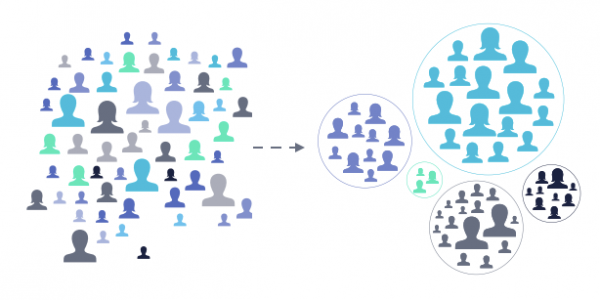

 Customer Segmentation is a practice of dividing a company's customers into groups that reflects the similarity among customers in each group. It can be done based on their needs, interests, priorities, by geography,etc.


With our dataset we are proceeding with RFM Segmentation.

# **Loading Packages**

We are loading the necessary packages for our code.

In [21]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install openpyxl

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer #, SilhouetteVisualizer, InterclusterDistance
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# **Import des données**


In [40]:
# df=pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx")
df = pd.read_csv('../data/rfm_total.csv')

In [41]:
# df['last_order'] = df['last_order'].astype('datetime64')
df['last_order'] = pd.to_datetime(df['last_order'], format='%Y-%m-%d %H:%M:%S')
df.dtypes

customer_unique_id                object
period                             int64
last_order                datetime64[ns]
frequency                          int64
monetary_value                   float64
total_dep_by_customer            float64
nb_products_buy                    int64
volume_product_cm3               float64
fav_categ                        float64
eval_mean_per_customer           float64
nb_of_comment                    float64
fav_payment_type                 float64
satisfaction_client              float64
recency                            int64
Cluster                            int64
dtype: object

# Echantillon réduit
## Préparation

In [42]:
# Importer les bibliothèques nécessaires
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Copier le DataFrame original pour éviter de modifier les données d'origine
df1 = df.copy()

# Échantillonner un sous-ensemble de données pour des performances plus rapides
data_reduce = df1.sample(10000, random_state=1).copy()

# Créer une copie du sous-ensemble de données
X_r = data_reduce.copy()

# Séparer les colonnes catégorielles et numériques
categorical_columns = X_r.select_dtypes(['category']).columns
numerical_columns = X_r.select_dtypes(['int32','int64', 'float64']).columns

# Initialiser l'encodeur One-Hot
ohe = OneHotEncoder(sparse=False)

# Initialiser le standardiseur (pour normaliser les données numériques)
ss = StandardScaler()

# Standardiser les données numériques
X_r[numerical_columns] = ss.fit_transform(X_r[numerical_columns])

# Adapter l'encodeur One-Hot aux colonnes catégorielles et les transformer
ohe.fit(X_r[categorical_columns])

# Créer un nouveau DataFrame en fusionnant les données numériques standardisées
# avec les colonnes encodées en utilisant les noms de colonnes générés par l'encodeur One-Hot
X_r = pd.merge(
    X_r[numerical_columns],  # Les données numériques standardisées
    pd.DataFrame(
        ohe.transform(X_r[categorical_columns]),  # Les colonnes catégorielles encodées
        columns=ohe.get_feature_names_out(categorical_columns),  # Noms de colonnes générés par l'encodeur
        index=X_r.index  # Conserver l'index d'origine
    ),
    left_index=True,  # Utiliser l'index de gauche pour la fusion
    right_index=True  # Utiliser l'index de droite pour la fusion
)


In [43]:
X_r

period  frequency  monetary_value  total_dep_by_customer  \
422    0.888855  -0.274818       -0.175523              -0.238373   
48663 -1.047585   3.808662        0.773098               3.177635   
86170  0.972143   1.086342        1.982039               2.561896   
84571 -1.214160  -0.274818       -0.423778              -0.373605   
13371  0.972143  -0.274818       -0.425708              -0.374657   
...         ...        ...             ...                    ...   
42009  0.951321  -0.274818       -0.073078              -0.182567   
10272  0.909677   5.169821        6.788227              20.527273   
70587  0.972143  -0.274818        1.600936               0.729325   
54473 -1.089229  -0.274818       -0.707330              -0.528066   
9329   0.972143  -0.274818       -0.654660              -0.499374   

       nb_products_buy  volume_product_cm3  fav_categ  eval_mean_per_customer  \
422          -0.274818           -0.440418   0.344129               -2.336670   
48663         3.808662           10.910680  -1.035822                0.684663   
86170         1.086342           -0.157873   1.011847                0.684663   
84571        -0.274818           -0.288552   1.590536               -0.070670   
13371        -0.274818           -0.395765   0.344129               -0.070670   
...                ...                 ...        ...                     ...   
42009        -0.274818            0.148091   0.833789               -0.070670   
10272         5.169821            5.284028   0.833789                0.684663   
70587        -0.274818            0.370402  -0.457133               -2.336670   
54473        -0.274818           -0.449348  -0.145531               -1.581337   
9329         -0.274818           -0.141058  -1.035822                0.684663   

       nb_of_comment  fav_payment_type  satisfaction_client   recency  \
422         0.670951          0.179625            -1.825070 -0.606858   
48663       4.660751          0.179625             0.547924  0.403433   
86170      -0.658982         -1.488199             0.547924 -1.425656   
84571       0.670951          0.179625             0.547924  1.889156   
13371      -0.658982          0.179625             0.547924 -1.498292   
...              ...               ...                  ...       ...   
42009       0.670951          0.179625             0.547924 -1.253973   
10272      -0.658982          0.179625             0.547924 -0.831367   
70587       0.670951          1.847448            -1.825070 -1.425656   
54473      -0.658982          0.179625            -1.825070  0.627942   
9329        0.670951          0.179625             0.547924 -1.392640   

        Cluster  
422   -1.980025  
48663  2.662471  
86170  0.341223  
84571  0.341223  
13371  0.341223  
...         ...  
42009  0.341223  
10272  2.662471  
70587 -1.980025  
54473 -1.980025  
9329   0.341223  

[10000 rows x 13 columns]

## PCA Transformation 

In [6]:
from sklearn.decomposition import PCA
pca_r = PCA(random_state=1)

In [7]:
pca_r.fit(X_r)

PCA(random_state=1)

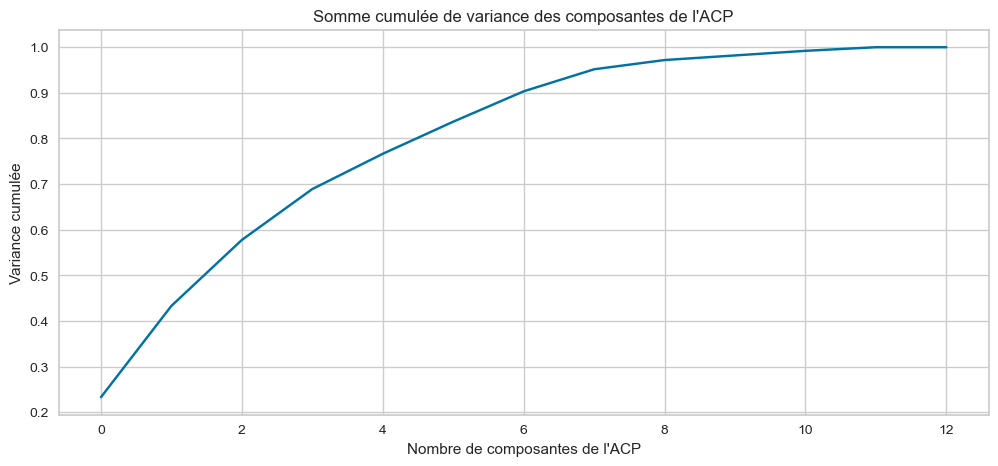

In [8]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(X_r.shape[1])),
         np.cumsum(pca_r.explained_variance_ratio_))

In [9]:
np.cumsum(pca_r.explained_variance_ratio_)[7]

0.9516691016285848

avec 7 features on a 94 % de la variance totale

In [10]:
colonnes_pca_r = X_r.columns

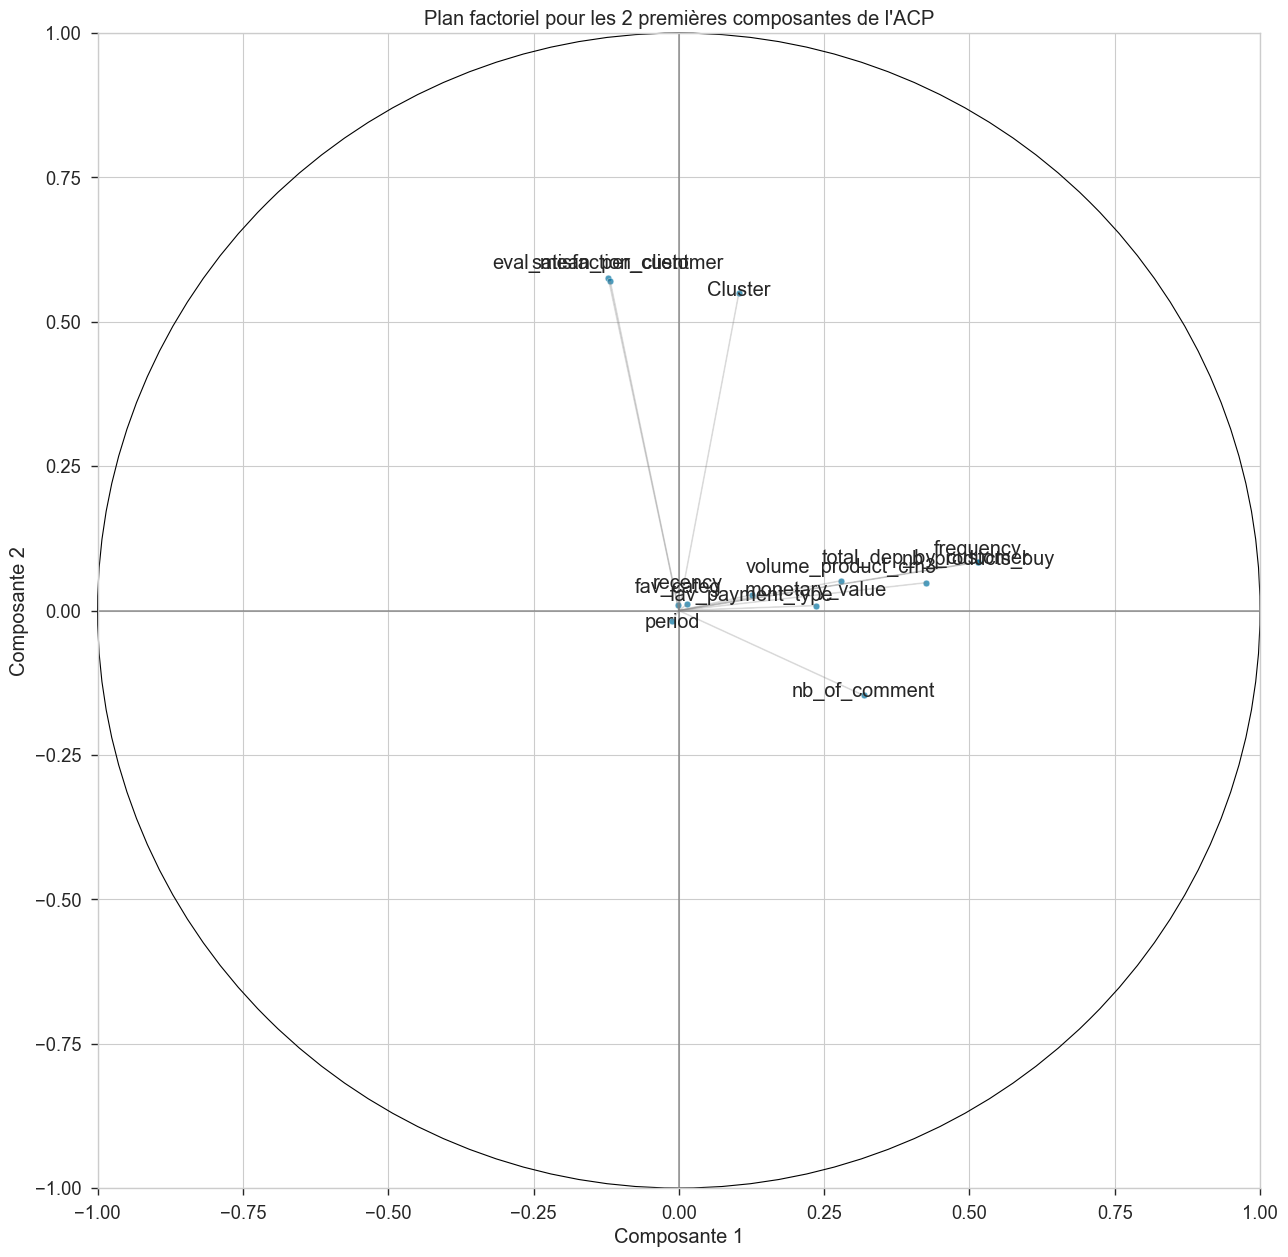

In [11]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(15,15))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()
ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', 
                    clip_on=False))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
x_pca = pca_r.components_[0,:]
y_pca = pca_r.components_[1,:]

sns.scatterplot(x = x_pca,
                y = y_pca,
               alpha = 0.7)
plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

i = 0
for x,y,colonne in zip(x_pca,y_pca, colonnes_pca_r):

    plt.annotate(colonne, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,5+np.random.randint(-10,10)),
                 ha='center') 
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',
             alpha=0.2)


sns.set_context("paper", font_scale=1) 

In [12]:
x_show = pca_r.transform(X_r.select_dtypes(['float64','int64']))[:,0]

y_show = pca_r.transform(X_r.select_dtypes(['float64','int64']))[:,1]

z_show = pca_r.transform(X_r.select_dtypes(['float64','int64']))[:,2]

In [13]:
X_pca_r = pca_r.transform(X_r)[:,:7]

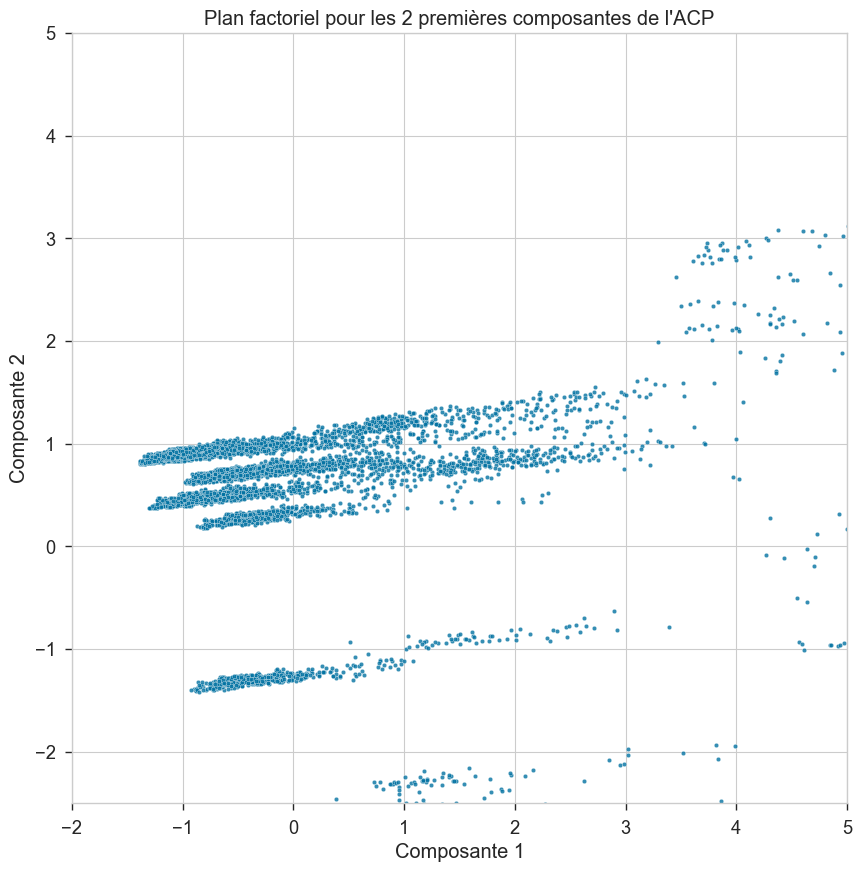

In [14]:
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10,10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()

# Limitez les axes x et y à des valeurs entre 0 et 10
plt.xlim(-2, 5)
plt.ylim(-2.5, 5)

sns.scatterplot(x = x_show,
                y = y_show,
                #hue = hue_show,
                alpha=0.8, s=10)

sns.set_context("paper", font_scale=1) 

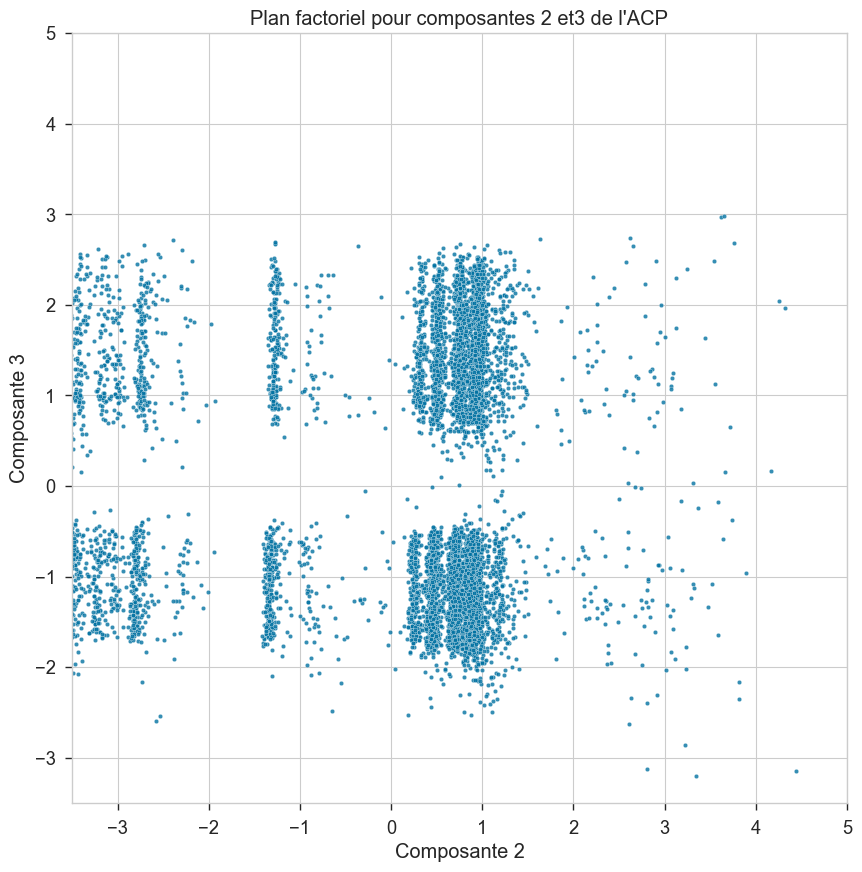

In [15]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10,10))
chaine = "Plan factoriel pour composantes 2 et3 de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 2')
plt.ylabel('Composante 3')
ax = plt.gca()

# Limitez les axes x et y à des valeurs entre 0 et 10
plt.xlim(-3.5, 5)
plt.ylim(-3.5, 5)

sns.scatterplot(x = y_show,
                y = z_show,
                #hue = hue_show,
                alpha=0.8, s=10)

sns.set_context("paper", font_scale=1) 

## Kmeans

# Premier essai

In [25]:
# Importez la classe KMeans du module sklearn.cluster
from sklearn.cluster import KMeans

# Créez une instance de KMeans avec 5 clusters, activez la sortie verbose pour voir les détails
# de l'ajustement du modèle, et fixez la graine aléatoire pour la reproductibilité.
kmeans_1e = KMeans(n_clusters=5, verbose=1, random_state=0)

# Ajustez le modèle KMeans aux données X_pca_r (résultat de l'ACP)
kmeans_1e.fit(X_pca_r)

# Obtenez les étiquettes de cluster attribuées à chaque échantillon après l'ajustement du modèle.
# Ces étiquettes indiquent à quel cluster chaque échantillon appartient.
cluster_labels = kmeans_1e.labels_

Initialization complete
Iteration 0, inertia 95112.92770006067.
Iteration 1, inertia 66275.30939906836.
Iteration 2, inertia 63546.43227551132.
Iteration 3, inertia 62708.41445100235.
Iteration 4, inertia 62160.77858701178.
Iteration 5, inertia 61612.16328005783.
Iteration 6, inertia 61238.47647077478.
Iteration 7, inertia 61204.97140171986.
Iteration 8, inertia 61201.714983485144.
Converged at iteration 8: center shift 8.281413563807396e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 87113.87705264584.
Iteration 1, inertia 63777.54753144433.
Iteration 2, inertia 61920.24196185149.
Iteration 3, inertia 61478.13106383801.
Iteration 4, inertia 61348.805011423494.
Iteration 5, inertia 61299.55299375304.
Iteration 6, inertia 61277.67544984216.
Iteration 7, inertia 61262.44508141544.
Iteration 8, inertia 61250.92352616641.
Iteration 9, inertia 61243.761569360126.
Iteration 10, inertia 61231.39135404028.
Iteration 11, inertia 61218.37105030959.
Itera

### Recherche d'un optimum du nombre de clusters

NB : intertia = Sum of squared distances of samples to their closest cluster center.

In [26]:
inertia = {}
dict_kmeans = {}
# for k in range(1,25):
#     print(k)
#     kmeans_1s = KMeans(n_clusters=k,
#                    verbose=1,
#                    random_state=0).fit(X_pca_r)
#     inertia[k] = kmeans_1s.inertia_
#     dict_kmeans[k] = kmeans_1s
# inertia = {}
# dict_kmeans = {}

nb_boucles=3
max_clusters = 10

for k in range(1,nb_boucles+1):
    print('Boucle ',k)
    for i in range(1,max_clusters+1):
        kmeans_ns = KMeans(n_clusters=i,
                       verbose=1).fit(X_pca_r)
        inertia[(k,i)] = kmeans_ns.inertia_
        dict_kmeans[k,i] = kmeans_ns

Boucle  1
Initialization complete
Iteration 0, inertia 165444.11316288981.
Iteration 1, inertia 117431.65226236227.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 153941.03930060036.
Iteration 1, inertia 117431.65226236227.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 172884.14159644817.
Iteration 1, inertia 117431.65226236227.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 403096.7968286152.
Iteration 1, inertia 117431.65226236227.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 149329.6884278845.
Iteration 1, inertia 117431.65226236227.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 166877.78079157785.
Iteration 1, inertia 117431.65226236227.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 829826.4208568891.
Iteration 1, ine

Iteration 0, inertia 114773.45760693599.
Iteration 1, inertia 80259.41343265976.
Iteration 2, inertia 78131.21576445109.
Iteration 3, inertia 77411.26728488831.
Iteration 4, inertia 77233.58314476852.
Iteration 5, inertia 77228.00248058423.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 103348.39299550888.
Iteration 1, inertia 80751.34559031908.
Iteration 2, inertia 80386.65873194739.
Iteration 3, inertia 80269.70869525112.
Iteration 4, inertia 80238.10065308484.
Iteration 5, inertia 80232.64205680536.
Iteration 6, inertia 80224.1122691317.
Iteration 7, inertia 80223.17809130704.
Converged at iteration 7: center shift 6.370444688165001e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 106565.83007082829.
Iteration 1, inertia 81149.24400712282.
Iteration 2, inertia 80303.1892724272.
Iteration 3, inertia 80236.49703574915.
Iteration 4, inertia 80227.75706559446.
Iteration 5, inertia 80223.3752393727.
Conv

Iteration 0, inertia 83187.13534844414.
Iteration 1, inertia 62573.07212230805.
Iteration 2, inertia 60789.97933071101.
Iteration 3, inertia 60082.78499247015.
Iteration 4, inertia 59343.96026119287.
Iteration 5, inertia 58772.05710916786.
Iteration 6, inertia 58526.35293678549.
Iteration 7, inertia 58375.78039302782.
Iteration 8, inertia 58283.78855512064.
Iteration 9, inertia 58235.087350962385.
Iteration 10, inertia 58215.214268879165.
Iteration 11, inertia 58208.343927191876.
Iteration 12, inertia 58204.18275594186.
Iteration 13, inertia 58202.581653407164.
Iteration 14, inertia 58202.04046388717.
Converged at iteration 14: center shift 0.00011883727522457531 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 85459.86045426203.
Iteration 1, inertia 65696.08484108547.
Iteration 2, inertia 59410.35862047116.
Iteration 3, inertia 58272.95137871841.
Iteration 4, inertia 58217.920966583064.
Iteration 5, inertia 58206.61644362055.
Iteration 6, inertia 5

Iteration 0, inertia 76053.53663116693.
Iteration 1, inertia 56291.192770925365.
Iteration 2, inertia 55317.13635247933.
Iteration 3, inertia 54041.153825965936.
Iteration 4, inertia 53565.12475342254.
Iteration 5, inertia 53457.41333732232.
Iteration 6, inertia 53433.77018484475.
Iteration 7, inertia 53420.93670132828.
Iteration 8, inertia 53411.02430084192.
Iteration 9, inertia 53396.9813488415.
Iteration 10, inertia 53384.91296691292.
Iteration 11, inertia 53375.27807029714.
Iteration 12, inertia 53369.46879183276.
Iteration 13, inertia 53363.37767608773.
Iteration 14, inertia 53359.05852985022.
Iteration 15, inertia 53357.567465236876.
Iteration 16, inertia 53356.26527995136.
Iteration 17, inertia 53353.57442520524.
Iteration 18, inertia 53349.65383958304.
Iteration 19, inertia 53343.5811963834.
Iteration 20, inertia 53332.61069283836.
Iteration 21, inertia 53316.663782968404.
Iteration 22, inertia 53300.87811342772.
Iteration 23, inertia 53279.78411279028.
Iteration 24, inertia 53

Iteration 0, inertia 65003.994249754476.
Iteration 1, inertia 51044.909818840235.
Iteration 2, inertia 50105.95831479308.
Iteration 3, inertia 49655.844159141605.
Iteration 4, inertia 49562.09448532334.
Iteration 5, inertia 49535.1551684461.
Iteration 6, inertia 49524.20648387959.
Iteration 7, inertia 49520.71142938773.
Iteration 8, inertia 49518.84717519673.
Iteration 9, inertia 49517.97134286871.
Iteration 10, inertia 49517.333234486185.
Iteration 11, inertia 49516.70835490752.
Iteration 12, inertia 49516.557609496136.
Converged at iteration 12: center shift 6.20577908743961e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 65203.39142436013.
Iteration 1, inertia 52436.1846592626.
Iteration 2, inertia 51506.24756604669.
Iteration 3, inertia 51104.42808550419.
Iteration 4, inertia 50816.15812733544.
Iteration 5, inertia 50265.65621793909.
Iteration 6, inertia 49377.59492419541.
Iteration 7, inertia 49056.4738898997.
Iteration 8, inertia 48996.77

Iteration 0, inertia 60723.1520237606.
Iteration 1, inertia 48173.755774401034.
Iteration 2, inertia 47419.88239906765.
Iteration 3, inertia 47250.67872881443.
Iteration 4, inertia 47209.19799736056.
Iteration 5, inertia 47178.37720324635.
Iteration 6, inertia 47152.35135962501.
Iteration 7, inertia 47134.32434477099.
Iteration 8, inertia 47126.732872772984.
Iteration 9, inertia 47125.9337538275.
Converged at iteration 9: center shift 6.27893757200198e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 63863.94158431127.
Iteration 1, inertia 49091.22531612018.
Iteration 2, inertia 46951.78917340681.
Iteration 3, inertia 46463.81001555064.
Iteration 4, inertia 46231.479952781396.
Iteration 5, inertia 46175.28836281446.
Iteration 6, inertia 46162.35026185501.
Iteration 7, inertia 46157.765643678766.
Iteration 8, inertia 46156.41086887263.
Iteration 9, inertia 46155.85403850204.
Iteration 10, inertia 46155.367902015525.
Converged at iteration 10: cent

Iteration 0, inertia 61900.436773842855.
Iteration 1, inertia 48123.55926264054.
Iteration 2, inertia 46311.95444031854.
Iteration 3, inertia 45967.059730512774.
Iteration 4, inertia 45762.11400306306.
Iteration 5, inertia 45635.4526158659.
Iteration 6, inertia 45609.68354111763.
Iteration 7, inertia 45597.113105203964.
Iteration 8, inertia 45593.93586386579.
Iteration 9, inertia 45592.42389940822.
Iteration 10, inertia 45590.05783735096.
Iteration 11, inertia 45586.77256808875.
Iteration 12, inertia 45584.48664496659.
Iteration 13, inertia 45583.546307973746.
Iteration 14, inertia 45583.03941206403.
Iteration 15, inertia 45582.22057328574.
Iteration 16, inertia 45582.05753864616.
Iteration 17, inertia 45581.856573678364.
Iteration 18, inertia 45581.75555495246.
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 68519.60385969013.
Iteration 1, inertia 51710.65781871328.
Iteration 2, inertia 49188.51864665439.
Iteration 3, inertia 47751.304516556

Iteration 0, inertia 170229.03493663098.
Iteration 1, inertia 96423.95397231699.
Iteration 2, inertia 94229.0230685767.
Iteration 3, inertia 94185.58377293064.
Iteration 4, inertia 94169.87258284619.
Iteration 5, inertia 94140.71362277627.
Iteration 6, inertia 94058.0208043635.
Iteration 7, inertia 93962.00610149415.
Iteration 8, inertia 93951.20923689273.
Iteration 9, inertia 93948.95176581515.
Converged at iteration 9: center shift 7.1592298254357714e-06 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 132901.80600983585.
Iteration 1, inertia 94120.60290806417.
Iteration 2, inertia 93986.4176801673.
Iteration 3, inertia 93954.08714824595.
Iteration 4, inertia 93948.93165680187.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 140395.54496238643.
Iteration 1, inertia 100865.53453969111.
Iteration 2, inertia 100206.04127928865.
Iteration 3, inertia 100149.54935612908.
Iteration 4, inertia 100143.71153147702.

Iteration 0, inertia 90317.66992098022.
Iteration 1, inertia 64835.67274281461.
Iteration 2, inertia 63878.47231275797.
Iteration 3, inertia 63840.52556699448.
Iteration 4, inertia 63837.82971488025.
Iteration 5, inertia 63837.2709536259.
Converged at iteration 5: center shift 2.272825594660173e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 93464.01959540846.
Iteration 1, inertia 78316.62667718314.
Iteration 2, inertia 77658.14109110509.
Iteration 3, inertia 77403.02336648386.
Iteration 4, inertia 77180.6495207039.
Iteration 5, inertia 76675.65528213653.
Iteration 6, inertia 75572.79870765342.
Iteration 7, inertia 71122.20800252688.
Iteration 8, inertia 66920.88448933166.
Iteration 9, inertia 65653.02781807768.
Iteration 10, inertia 64921.67593512765.
Iteration 11, inertia 64369.33674849184.
Iteration 12, inertia 63958.17480639068.
Iteration 13, inertia 63842.556100730704.
Iteration 14, inertia 63837.58170323551.
Iteration 15, inertia 63837.22

Iteration 0, inertia 80007.08699223044.
Iteration 1, inertia 64420.02474561551.
Iteration 2, inertia 60747.192740917584.
Iteration 3, inertia 60531.85009291665.
Iteration 4, inertia 60517.46084476867.
Iteration 5, inertia 60517.23448017776.
Converged at iteration 5: center shift 2.538388518378845e-06 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 84252.7581322698.
Iteration 1, inertia 59633.91406451107.
Iteration 2, inertia 58541.57312958372.
Iteration 3, inertia 58386.22821549323.
Iteration 4, inertia 58278.81667900292.
Iteration 5, inertia 58027.73739864139.
Iteration 6, inertia 57248.20980231506.
Iteration 7, inertia 55922.079818122.
Iteration 8, inertia 54962.649625851904.
Iteration 9, inertia 54771.53003694257.
Iteration 10, inertia 54743.889674083024.
Iteration 11, inertia 54734.42016342087.
Iteration 12, inertia 54728.99702009745.
Iteration 13, inertia 54728.360796421686.
Converged at iteration 13: center shift 8.124355018992652e-05 within 

Iteration 0, inertia 69269.25524013425.
Iteration 1, inertia 54227.96865022041.
Iteration 2, inertia 53237.71069491641.
Iteration 3, inertia 53066.93783367199.
Iteration 4, inertia 52974.251383649535.
Iteration 5, inertia 52895.29297301716.
Iteration 6, inertia 52791.88418815305.
Iteration 7, inertia 52635.58476746946.
Iteration 8, inertia 52349.88624934295.
Iteration 9, inertia 52000.83524741169.
Iteration 10, inertia 51945.19797393575.
Iteration 11, inertia 51924.32370735183.
Iteration 12, inertia 51914.79205875977.
Iteration 13, inertia 51913.71900369588.
Iteration 14, inertia 51913.376610008.
Converged at iteration 14: center shift 0.00011189308913403951 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 77649.85181843834.
Iteration 1, inertia 56074.49870923999.
Iteration 2, inertia 54503.88194519875.
Iteration 3, inertia 53601.521904355744.
Iteration 4, inertia 52995.48611462504.
Iteration 5, inertia 52737.467790144416.
Iteration 6, inertia 52589

Iteration 0, inertia 73914.67008961487.
Iteration 1, inertia 52080.37907274404.
Iteration 2, inertia 49811.01353614517.
Iteration 3, inertia 49270.352548791634.
Iteration 4, inertia 49086.79900412727.
Iteration 5, inertia 49026.939463782335.
Iteration 6, inertia 49008.91848736281.
Iteration 7, inertia 48999.14475333834.
Iteration 8, inertia 48994.21395773399.
Iteration 9, inertia 48988.17774309066.
Iteration 10, inertia 48987.33225643606.
Iteration 11, inertia 48986.6856875809.
Iteration 12, inertia 48984.039140755805.
Iteration 13, inertia 48980.62410695398.
Iteration 14, inertia 48975.452407073.
Iteration 15, inertia 48971.50089978754.
Iteration 16, inertia 48966.32671038424.
Iteration 17, inertia 48962.03667232098.
Iteration 18, inertia 48960.037403582486.
Iteration 19, inertia 48959.57416817542.
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 73258.19304138169.
Iteration 1, inertia 53591.077826403955.
Iteration 2, inertia 50957.3695481534

Iteration 0, inertia 71045.27356643132.
Iteration 1, inertia 50230.483609324205.
Iteration 2, inertia 48628.66349211203.
Iteration 3, inertia 48259.57026749963.
Iteration 4, inertia 48120.694029498205.
Iteration 5, inertia 48069.6200363994.
Iteration 6, inertia 48050.47560018653.
Iteration 7, inertia 48035.9431637647.
Iteration 8, inertia 48007.77039681999.
Iteration 9, inertia 47987.013445145436.
Iteration 10, inertia 47977.82147685939.
Iteration 11, inertia 47975.171932251935.
Iteration 12, inertia 47974.15033509516.
Iteration 13, inertia 47973.70287530532.
Iteration 14, inertia 47973.32841977774.
Converged at iteration 14: center shift 0.0001046495643195635 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 63877.46623378774.
Iteration 1, inertia 53379.149329977234.
Iteration 2, inertia 52494.28137739602.
Iteration 3, inertia 51890.30765380191.
Iteration 4, inertia 50858.113061698845.
Iteration 5, inertia 50084.73203398354.
Iteration 6, inertia 497

Iteration 0, inertia 57886.2685958124.
Iteration 1, inertia 46558.1659366824.
Iteration 2, inertia 45785.661676188705.
Iteration 3, inertia 45670.94490813613.
Iteration 4, inertia 45617.8940952829.
Iteration 5, inertia 45609.260131875824.
Iteration 6, inertia 45596.68591292302.
Iteration 7, inertia 45591.54205766302.
Iteration 8, inertia 45590.237634573554.
Iteration 9, inertia 45589.62422288852.
Iteration 10, inertia 45589.162526633954.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 60598.57727435391.
Iteration 1, inertia 47579.708745199016.
Iteration 2, inertia 47168.20731065663.
Iteration 3, inertia 47057.487753927046.
Iteration 4, inertia 46956.43276005382.
Iteration 5, inertia 46896.43170302932.
Iteration 6, inertia 46868.210627872206.
Iteration 7, inertia 46847.22172550774.
Iteration 8, inertia 46829.9653978208.
Iteration 9, inertia 46810.12904445343.
Iteration 10, inertia 46774.06527341946.
Iteration 11, inertia 46743.673855124056.
It

Iteration 0, inertia 125750.14704668346.
Iteration 1, inertia 88152.0511155225.
Iteration 2, inertia 85499.43912075149.
Iteration 3, inertia 84888.44864771822.
Iteration 4, inertia 84708.51729924267.
Iteration 5, inertia 84574.35153939154.
Iteration 6, inertia 84387.99966772136.
Iteration 7, inertia 84200.69505459024.
Iteration 8, inertia 83949.78461004383.
Iteration 9, inertia 83743.19134011203.
Iteration 10, inertia 83718.6206157421.
Iteration 11, inertia 83716.98339747511.
Iteration 12, inertia 83716.62999798055.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 107086.31597170087.
Iteration 1, inertia 83022.4998434835.
Iteration 2, inertia 80444.71480450619.
Iteration 3, inertia 80256.54479236396.
Iteration 4, inertia 80231.45226035881.
Iteration 5, inertia 80223.35129871822.
Converged at iteration 5: center shift 0.00014715658592860073 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 100364.11794539074.

Iteration 0, inertia 89673.42979264238.
Iteration 1, inertia 68985.5875325473.
Iteration 2, inertia 64892.324415489275.
Iteration 3, inertia 63870.02024576919.
Iteration 4, inertia 63842.460773405044.
Iteration 5, inertia 63837.994910035544.
Iteration 6, inertia 63837.2709536259.
Converged at iteration 6: center shift 2.272825594659882e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 87402.0955942111.
Iteration 1, inertia 67043.69800988649.
Iteration 2, inertia 64645.14154506129.
Iteration 3, inertia 64041.886355657494.
Iteration 4, inertia 63857.799189993246.
Iteration 5, inertia 63839.173682511115.
Iteration 6, inertia 63837.529976347156.
Converged at iteration 6: center shift 9.521338402569323e-05 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 100708.27518034609.
Iteration 1, inertia 80402.25999962993.
Iteration 2, inertia 78381.18114430054.
Iteration 3, inertia 78224.3735625023.
Iteration 4, inertia 781

Iteration 0, inertia 91373.50882760392.
Iteration 1, inertia 65781.80978384623.
Iteration 2, inertia 60345.077952648855.
Iteration 3, inertia 57827.44507854068.
Iteration 4, inertia 57519.12010713047.
Iteration 5, inertia 57411.598766475116.
Iteration 6, inertia 57371.204013159084.
Iteration 7, inertia 57339.93706597935.
Iteration 8, inertia 57322.88380623939.
Iteration 9, inertia 57316.903957553826.
Converged at iteration 9: center shift 0.00016256537293503776 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 81264.75728930921.
Iteration 1, inertia 60215.14184434409.
Iteration 2, inertia 57866.618222803954.
Iteration 3, inertia 56934.41981587304.
Iteration 4, inertia 56433.812757236636.
Iteration 5, inertia 56071.48227665311.
Iteration 6, inertia 55849.811450497364.
Iteration 7, inertia 55762.468993631664.
Iteration 8, inertia 55718.09076431186.
Iteration 9, inertia 55688.87270208464.
Iteration 10, inertia 55669.83195292044.
Iteration 11, inertia 55

Iteration 0, inertia 72601.66527255016.
Iteration 1, inertia 59554.9913491919.
Iteration 2, inertia 57297.31084025266.
Iteration 3, inertia 56273.785938417524.
Iteration 4, inertia 54987.99581786264.
Iteration 5, inertia 53555.572294394806.
Iteration 6, inertia 52906.39663742113.
Iteration 7, inertia 52630.26801452297.
Iteration 8, inertia 52439.54613492564.
Iteration 9, inertia 52353.70610759836.
Iteration 10, inertia 52339.75912978043.
Iteration 11, inertia 52329.06167892311.
Iteration 12, inertia 52316.50683448822.
Iteration 13, inertia 52307.869117597504.
Iteration 14, inertia 52286.145667883335.
Iteration 15, inertia 52277.616577264314.
Iteration 16, inertia 52272.326136960895.
Iteration 17, inertia 52263.92967685583.
Iteration 18, inertia 52259.98697907492.
Iteration 19, inertia 52258.05555883653.
Iteration 20, inertia 52257.920239230225.
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 65720.59173566746.
Iteration 1, inertia 54000.15601

Iteration 0, inertia 70866.69632217781.
Iteration 1, inertia 53562.97291761244.
Iteration 2, inertia 52269.708869304544.
Iteration 3, inertia 51788.445726129925.
Iteration 4, inertia 51625.85262965937.
Iteration 5, inertia 51576.73564211595.
Iteration 6, inertia 51546.669803026554.
Iteration 7, inertia 51532.58234417583.
Iteration 8, inertia 51522.18416719395.
Iteration 9, inertia 51509.4939947826.
Iteration 10, inertia 51479.59931665338.
Iteration 11, inertia 51429.53244673898.
Iteration 12, inertia 51417.50315291298.
Iteration 13, inertia 51409.808499400344.
Iteration 14, inertia 51406.50618968982.
Iteration 15, inertia 51405.40560656841.
Iteration 16, inertia 51404.5760230379.
Converged at iteration 16: center shift 0.00014097330796126906 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 66891.94517679629.
Iteration 1, inertia 53829.15581388978.
Iteration 2, inertia 50959.607969264835.
Iteration 3, inertia 49808.46148039843.
Iteration 4, inertia 4

Iteration 0, inertia 68787.3612774075.
Iteration 1, inertia 49264.706895692325.
Iteration 2, inertia 47073.412329775536.
Iteration 3, inertia 46776.79453363572.
Iteration 4, inertia 46707.90534795573.
Iteration 5, inertia 46639.20007337692.
Iteration 6, inertia 46606.32054482722.
Iteration 7, inertia 46602.23126214571.
Iteration 8, inertia 46600.538719542645.
Iteration 9, inertia 46597.92393847933.
Iteration 10, inertia 46597.48693445446.
Converged at iteration 10: center shift 7.484658330144462e-06 within tolerance 0.00016775950323194572.
Initialization complete
Iteration 0, inertia 61235.90134951805.
Iteration 1, inertia 47956.90034905223.
Iteration 2, inertia 46668.74396126086.
Iteration 3, inertia 46212.79979461579.
Iteration 4, inertia 46050.24985437986.
Iteration 5, inertia 45969.46882997952.
Iteration 6, inertia 45928.07868427904.
Iteration 7, inertia 45898.76685096708.
Iteration 8, inertia 45852.902347950985.
Iteration 9, inertia 45756.59933664251.
Iteration 10, inertia 45614.5

Iteration 0, inertia 56490.85448436593.
Iteration 1, inertia 47958.93410313428.
Iteration 2, inertia 47007.70304894743.
Iteration 3, inertia 46784.97092149382.
Iteration 4, inertia 46719.43526525125.
Iteration 5, inertia 46634.305909767085.
Iteration 6, inertia 46491.8383800521.
Iteration 7, inertia 46388.69412995495.
Iteration 8, inertia 46301.2030293283.
Iteration 9, inertia 46200.808303664635.
Iteration 10, inertia 46125.01118372317.
Iteration 11, inertia 46098.108523772244.
Iteration 12, inertia 46077.31141211698.
Iteration 13, inertia 46060.10550305302.
Iteration 14, inertia 46038.906828728606.
Iteration 15, inertia 45963.52462423658.
Iteration 16, inertia 45832.19962287348.
Iteration 17, inertia 45693.38807327014.
Iteration 18, inertia 45462.89830304656.
Iteration 19, inertia 45324.62897602783.
Iteration 20, inertia 45288.0367413863.
Iteration 21, inertia 45259.75347306033.
Iteration 22, inertia 45219.225292775256.
Iteration 23, inertia 45135.427079478024.
Iteration 24, inertia 4

In [27]:
from sklearn.metrics import silhouette_score

silhouettes_kmeans = {}
max_clusters = 3
for i in range(2,max_clusters):
    silhouettes_kmeans[i] = silhouette_score(X = X_pca_r, labels= list(dict_kmeans[(1,i)].labels_))

## T-SNE

In [28]:
tsne = TSNE(n_components=2)
Tr = tsne.fit_transform(X_pca_r.copy())

utilisons l'algorithme T-SNE pour avoir une idée en première approche du nombre de groupes homogènes

<Axes: title={'center': 'Représentation du jeu de données via T-SNE'}>

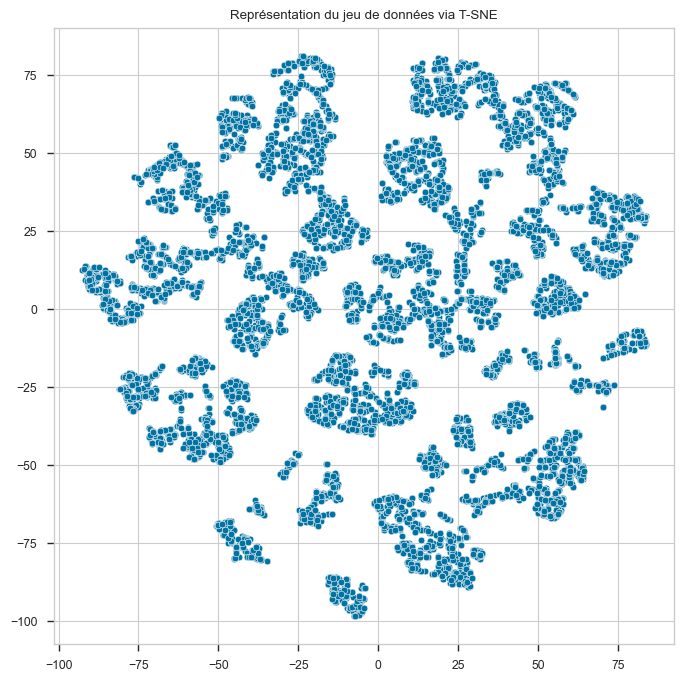

In [44]:
plt.figure(figsize=(8,8))
plt.title('Représentation du jeu de données via T-SNE')
sns.scatterplot(x=Tr[:, 0],  # Coordonnées x
                y=Tr[:, 1])  # Coordonnées y


utilisons l'algorithme T-SNE pour avoir une idée de la séparation du jeu de données via KMeans (3 clusters)

<Axes: title={'center': 'Représentation T-SNE de la séparation du jeu de données via KMeans (3 clusters)'}>

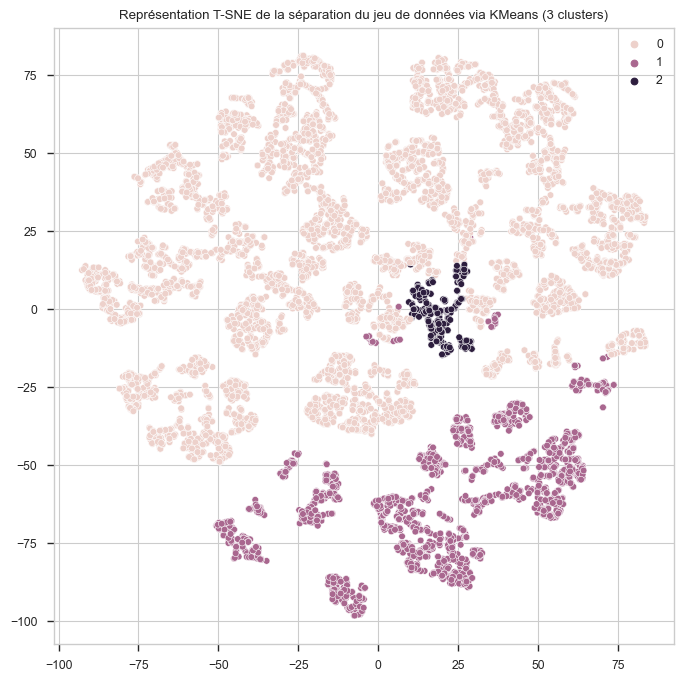

In [45]:
plt.figure(figsize=(8, 8))
plt.title('Représentation T-SNE de la séparation du jeu de données via KMeans (3 clusters)')
sns.scatterplot(x=Tr[:, 0],  # Coordonnées x
                y=Tr[:, 1],  # Coordonnées y
                hue=dict_kmeans[(1, 3)].labels_,  # Étiquettes des clusters
                legend='full')


## DBSCAN

### Application

In [46]:
dbs = DBSCAN(eps = 1, min_samples=5).fit(X_pca_r.copy())

<Axes: title={'center': 'Représentation de la séparation des données du DBSCAN via T-SNE'}>

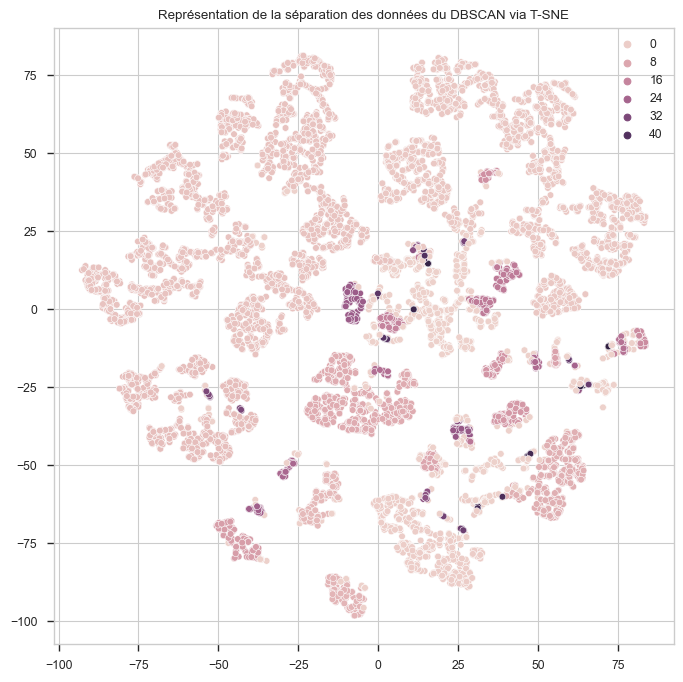

In [49]:
plt.figure(figsize=(8, 8))
plt.title('Représentation de la séparation des données du DBSCAN via T-SNE')
sns.scatterplot(x=Tr[:, 0], y=Tr[:, 1], hue=dbs.labels_)


## Clustering Hiérarchique

In [50]:
nb_clusters_agg = 3

In [51]:
ac = AgglomerativeClustering(n_clusters = nb_clusters_agg
                             ).fit(X_pca_r.copy())

In [52]:
from sklearn.cluster import AgglomerativeClustering

# Créez et ajustez le modèle AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=nb_clusters_agg).fit(X_pca_r.copy())

# Obtenez les labels prédits à partir du modèle
labels_ = ac.labels_

# Créez un DataFrame avec les données
graph = pd.DataFrame(data={'X': Tr[:, 0], 'Y': Tr[:, 1], 'label_kmeans': labels_})


In [53]:
graph['x_pca'] = x_show
graph['y_pca'] = y_show
graph['z_pca'] = z_show

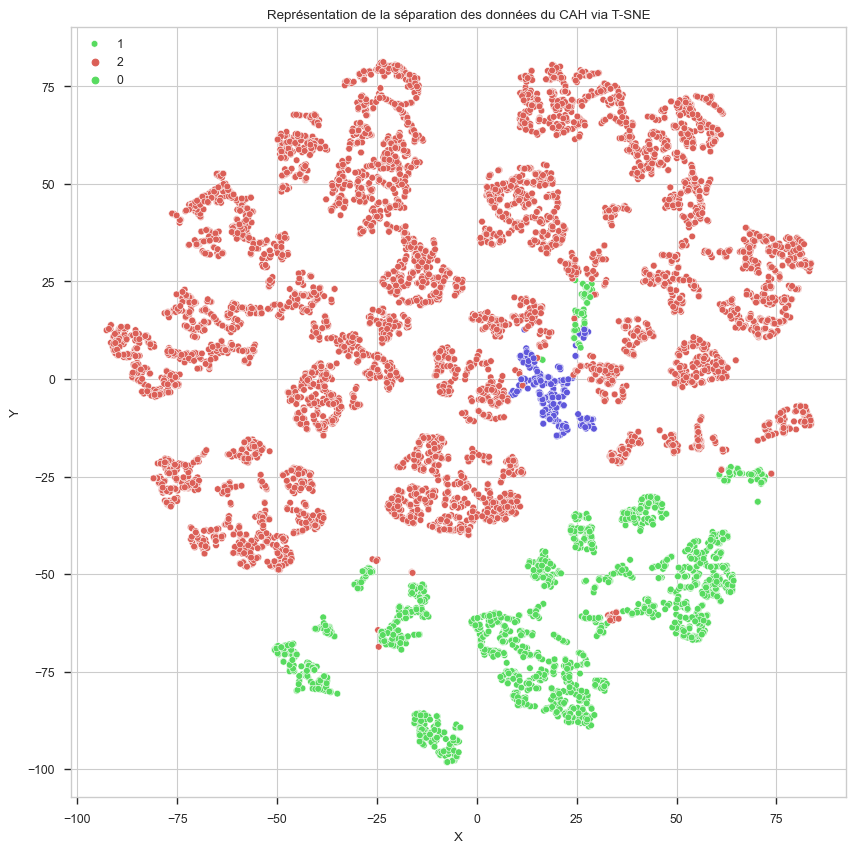

In [55]:
plt.figure(figsize=(10, 10))
plt.title('Représentation de la séparation des données du CAH via T-SNE')
sns.scatterplot(x=graph['X'], y=graph['Y'], hue=ac.labels_, legend='full', palette=sns.color_palette("hls", nb_clusters_agg))
plt.legend(loc='upper left', labels=graph['label_kmeans'].unique())
plt.show()


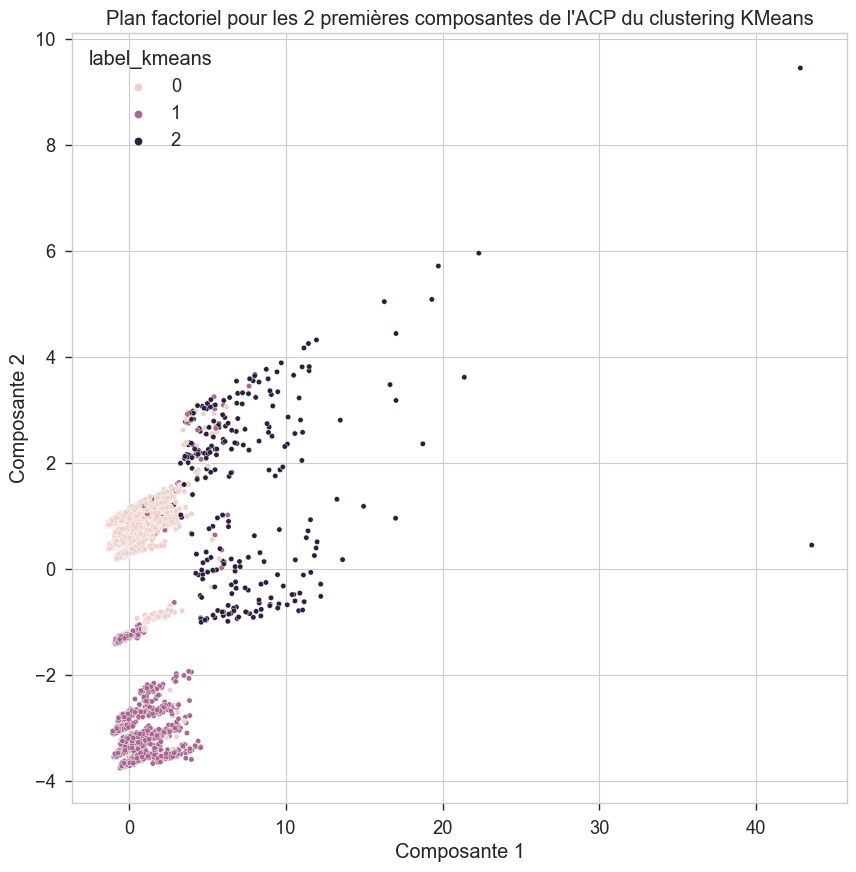

In [57]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10,10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP \
du clustering KMeans"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()

# # Limitez les axes x et y à des valeurs entre 0 et 10
# plt.xlim(-2, 5)
# plt.ylim(-2.5, 5)

sns.scatterplot(x = graph['x_pca'], 
                y = graph['y_pca'], 
                hue = graph['label_kmeans'],
                alpha=1, s=15, legend='full')

sns.set_context("paper", font_scale=1) 

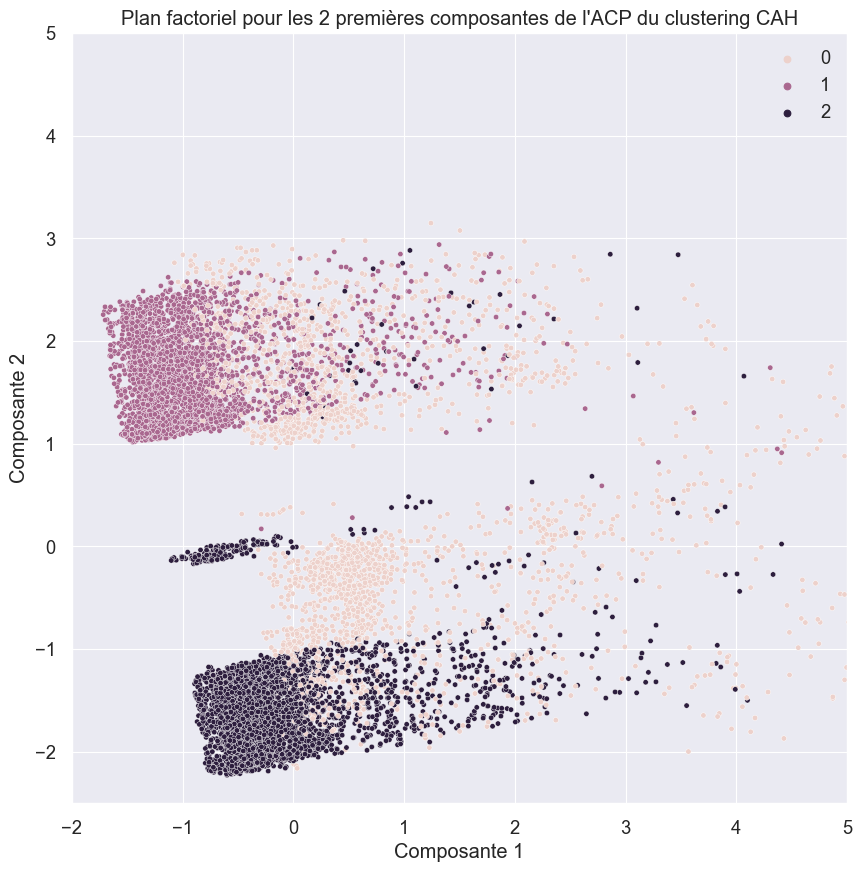

In [264]:
from matplotlib.patches import Circle
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10, 10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP du clustering CAH"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()

# Limitez les axes x et y à des valeurs entre 0 et 10
plt.xlim(-2, 5)
plt.ylim(-2.5, 5)

sns.scatterplot(x=graph['x_pca'], 
                y=graph['y_pca'], 
                hue=ac.labels_,
                alpha=1, s=15, legend='full')

sns.set_context("paper", font_scale=1)


# Autre analyse 
## **RFM Analysis**

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer. So, RFM analysis can be carried out only on customers who have customerID.

**RFM Metrics**

**Recency**  : It is the amount of time since the customers most recent transaction. It is measured                 in days.
 
**Frequency**: Total number of transactions made by the customer.
 
**Monetary** : Total amount the customer has spent across all transactions.

In [58]:
# rfm.columns = ['recency', 'frequency', 'monetary']
# rfm = df[['recency', 'frequency', 'monetary_value']]
rfm = df.copy()
rfm = rfm[rfm["monetary_value"] > 0]
rfm.head()

customer_unique_id  period          last_order  frequency  \
0  2ce5d2f1052c47331ae94aa3551f15ed  201708 2017-08-04 11:35:21          1   
1  65811efa36585c22a9931b8480af1f22  201803 2018-03-07 19:30:10          1   
2  8021302579cee7312c300290e35d490e  201803 2018-03-21 12:59:12          1   
3  96b5b2e02beee64d4767aa546b4984ef  201801 2018-01-21 21:42:20          1   
4  59a17dcfcbfb81e6426ba122a8bbf5cb  201806 2018-06-24 07:54:55          1   

   monetary_value  total_dep_by_customer  nb_products_buy  volume_product_cm3  \
0           40.00                  40.00                1              4212.0   
1          153.39                 153.39                1             71944.0   
2           42.77                  42.77                1              5776.0   
3          158.30                 158.30                1              2816.0   
4           40.24                  40.24                1              4096.0   

   fav_categ  eval_mean_per_customer  nb_of_comment  fav_payment_type  \
0       67.0                     5.0            0.0               0.0   
1       14.0                     4.0            1.0               0.0   
2       33.0                     1.0            1.0               1.0   
3        0.0                     2.0            1.0               1.0   
4       14.0                     4.0            0.0               1.0   

   satisfaction_client  recency  Cluster  
0                  1.0      392        1  
1                  1.0      177        1  
2                  0.0      163        0  
3                  0.0      222        0  
4                  1.0       68        1

### **Calculate the score**

We need to assign a score from 1 to 5 to recency, frequency and monetary value individually for each customer.

Below is the **conversion** of columns into rfm scores between 1 to 5. 

**'5'** being the **highest** and **'1'** being the **least**.

- The higher the **monetary** value, higher is the score ie,'5' . 


- Smaller value of **recency** indicates recent purchases, so it takes the higher value of 5. 


- Frequency is the same as monetary, higher the **frequency**, higher the score.

Calculer le score

Nous devons attribuer un score de 1 à 5 à la récence, à la fréquence et à la valeur monétaire individuellement pour chaque client.

Vous trouverez ci-dessous la conversion des colonnes en scores rfm compris entre 1 et 5.

« 5 » étant le plus élevé et « 1 » le moins élevé.

Plus la valeur monétaire est élevée, plus le score est élevé, c'est-à-dire « 5 ».

Une valeur de récence plus petite indique des achats récents, elle prend donc la valeur la plus élevée de 5.

La fréquence est la même que celle monétaire, plus la fréquence est élevée, plus le score est élevé.

In [59]:
# rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])


# rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# rfm['score']=rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)

# Calculer les scores de recency en divisant les données en 5 intervalles et en attribuant des étiquettes de score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

# Calculer les scores de frequency en divisant les données en 5 intervalles et en attribuant des étiquettes de score
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Calculer les scores de monetary en divisant les données en 5 intervalles et en attribuant des étiquettes de score
rfm["monetary_score"] = pd.qcut(rfm['monetary_value'], 5, labels=[1, 2, 3, 4, 5])

# Calculer le score total en additionnant les scores de recency, frequency et monetary
rfm['score'] = rfm['recency_score'].astype(int) + rfm['frequency_score'].astype(int) + rfm['monetary_score'].astype(int)


In [60]:
rfm.head()

customer_unique_id  period          last_order  frequency  \
0  2ce5d2f1052c47331ae94aa3551f15ed  201708 2017-08-04 11:35:21          1   
1  65811efa36585c22a9931b8480af1f22  201803 2018-03-07 19:30:10          1   
2  8021302579cee7312c300290e35d490e  201803 2018-03-21 12:59:12          1   
3  96b5b2e02beee64d4767aa546b4984ef  201801 2018-01-21 21:42:20          1   
4  59a17dcfcbfb81e6426ba122a8bbf5cb  201806 2018-06-24 07:54:55          1   

   monetary_value  total_dep_by_customer  nb_products_buy  volume_product_cm3  \
0           40.00                  40.00                1              4212.0   
1          153.39                 153.39                1             71944.0   
2           42.77                  42.77                1              5776.0   
3          158.30                 158.30                1              2816.0   
4           40.24                  40.24                1              4096.0   

   fav_categ  eval_mean_per_customer  nb_of_comment  fav_payment_type  \
0       67.0                     5.0            0.0               0.0   
1       14.0                     4.0            1.0               0.0   
2       33.0                     1.0            1.0               1.0   
3        0.0                     2.0            1.0               1.0   
4       14.0                     4.0            0.0               1.0   

   satisfaction_client  recency  Cluster recency_score frequency_score  \
0                  1.0      392        1             1               1   
1                  1.0      177        1             4               1   
2                  0.0      163        0             4               1   
3                  0.0      222        0             3               1   
4                  1.0       68        1             5               1   

  monetary_score  score  
0              1      3  
1              4      9  
2              1      6  
3              4      8  
4              1      7

In [61]:
unique_scores = rfm['score'].unique()
print(unique_scores)


[ 3  9  6  8  7 14 11 12 10  5 15 13  4]


### Best customers

With the help of score, we will be able to identify the best customers in our e-commerce company.

In [62]:
rfm[rfm['score']>= 15].sort_values('monetary_value', ascending=False).head()

customer_unique_id  period          last_order  \
39567  91049771b745aa43500e4c82ed6a2241  201807 2018-07-19 12:59:52   
21021  3f9bb1cc786f6a4ecfd6b3d868d39357  201808 2018-08-20 16:26:49   
19058  96e91c0dba30f7ff60c9acd47677c248  201807 2018-07-18 12:59:21   
65626  fb71ed60806ae68abb00194fa02647a4  201808 2018-08-13 23:03:46   
28541  e015ce18751465bc79eeabbe3f0064d5  201808 2018-08-06 09:29:23   

       frequency  monetary_value  total_dep_by_customer  nb_products_buy  \
39567          2         1388.98                2777.96                2   
21021          2         1377.99                2755.98                2   
19058          6         1351.44                8108.64                6   
65626          2         1341.26                2682.52                2   
28541          5         1253.03                6265.15                5   

       volume_product_cm3  fav_categ  eval_mean_per_customer  nb_of_comment  \
39567              8192.0       14.0                     5.0            2.0   
21021             77274.0       62.0                     5.0            2.0   
19058            428868.0       56.0                     4.0            6.0   
65626             62896.0       55.0                     2.0            0.0   
28541            130500.0       13.0                     5.0            0.0   

       fav_payment_type  satisfaction_client  recency  Cluster recency_score  \
39567               0.0                  1.0       43        2             5   
21021               1.0                  1.0       11        2             5   
19058               0.0                  1.0       44        2             5   
65626               1.0                  0.0       18        2             5   
28541               1.0                  1.0       25        2             5   

      frequency_score monetary_score  score  
39567               5              5     15  
21021               5              5     15  
19058               5              5     15  
65626               5              5     15  
28541               5              5     15

The customers having a score of '15' are considered as the 'best customers' as they have have the highest recency, frequency and monetary score.

They are asset to the company.

### **Number of best customers** 

In [63]:
rfm[rfm['score']>=15].count()

customer_unique_id        1027
period                    1027
last_order                1027
frequency                 1027
monetary_value            1027
total_dep_by_customer     1027
nb_products_buy           1027
volume_product_cm3        1027
fav_categ                 1027
eval_mean_per_customer    1027
nb_of_comment             1027
fav_payment_type          1027
satisfaction_client       1027
recency                   1027
Cluster                   1027
recency_score             1027
frequency_score           1027
monetary_score            1027
score                     1027
dtype: int64

There are 349 Best customers in the company who are frequent buyers and also generate high revenue.

## **Separation des clients **

Nous allons **séparer** le niveau du client **en fonction du score**.

Ici, nous les avons classés en **4 niveaux**.

**Bon** : Génération de revenus élevés et acheteurs fréquents.

**Moyen** : Clients dont les achats sont assez fréquents et génèrent des revenus modérés.

**Mauvais** : Clients moins actifs, acheteurs peu fréquents et générant de faibles revenus.

In [64]:
# def rfm_level(score):
#     if  ((score >1) and (score < 4)):
#         return 'Inactif'
#     elif ((score >3) and (score < 8)):
#         return 'Moyen'
#     elif ((score > 7) and (score <11)):
#         return 'Bon'
#     else:
#         return 'Meilleur'
    
def rfm_level(score):
    if  (score >= 8):
        return 'Bon'
    elif (score >= 4):
        return 'Moyen'
    else:
        return 'Mauvais'
    

In [65]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

customer_unique_id  period          last_order  frequency  \
0  2ce5d2f1052c47331ae94aa3551f15ed  201708 2017-08-04 11:35:21          1   
1  65811efa36585c22a9931b8480af1f22  201803 2018-03-07 19:30:10          1   
2  8021302579cee7312c300290e35d490e  201803 2018-03-21 12:59:12          1   
3  96b5b2e02beee64d4767aa546b4984ef  201801 2018-01-21 21:42:20          1   
4  59a17dcfcbfb81e6426ba122a8bbf5cb  201806 2018-06-24 07:54:55          1   

   monetary_value  total_dep_by_customer  nb_products_buy  volume_product_cm3  \
0           40.00                  40.00                1              4212.0   
1          153.39                 153.39                1             71944.0   
2           42.77                  42.77                1              5776.0   
3          158.30                 158.30                1              2816.0   
4           40.24                  40.24                1              4096.0   

   fav_categ  eval_mean_per_customer  nb_of_comment  fav_payment_type  \
0       67.0                     5.0            0.0               0.0   
1       14.0                     4.0            1.0               0.0   
2       33.0                     1.0            1.0               1.0   
3        0.0                     2.0            1.0               1.0   
4       14.0                     4.0            0.0               1.0   

   satisfaction_client  recency  Cluster recency_score frequency_score  \
0                  1.0      392        1             1               1   
1                  1.0      177        1             4               1   
2                  0.0      163        0             4               1   
3                  0.0      222        0             3               1   
4                  1.0       68        1             5               1   

  monetary_score  score    level  
0              1      3  Mauvais  
1              4      9      Bon  
2              1      6    Moyen  
3              4      8      Bon  
4              1      7    Moyen

### Visualising number of customers for each level

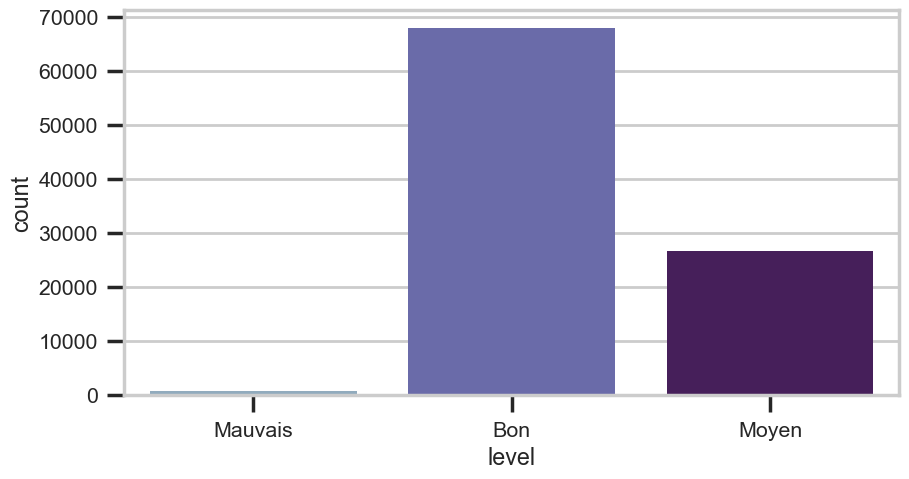

In [69]:
plt.figure(figsize=(10, 5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(x='level', data=rfm)
plt.show()


In [67]:
rfm.groupby('level').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary_value' : ['mean','min','max','count']
})

recency           frequency         monetary_value          \
               mean  min  max      mean min max           mean     min   
level                                                                    
Bon      198.776509    2  602  1.271438   1  36     172.981708   3.575   
Mauvais  480.257212  387  603  1.000000   1   1      38.765661  18.190   
Moyen    341.668836    2  603  1.037243   1  34      76.899360   4.680   

                         
             max  count  
level                    
Bon      1404.24  67846  
Mauvais    53.01    832  
Moyen    1257.96  26582

**Bon (Bon Clients) :**
On peut dire que 52,574 clients ont acheté en moyenne 239,63 unités en faisant leurs achats environ tous les 148 jours. Ce sont des clients privilégiés. Vous pouvez envisager de proposer des offres spéciales ou des promotions pour les inciter à faire des achats plus fréquents.

**Moyen (Clients Moyens) :**
Environ 20,009 clients ont acheté en moyenne 90,00 unités en faisant leurs achats environ tous les 241 jours. Ces clients montrent un comportement d'achat moyen. Vous pouvez envisager d'envoyer des offres de fidélisation pour les encourager à acheter plus fréquemment.

**Mauvais (Clients Mauvais) :**
Environ 561 clients ont acheté en moyenne 40,19 unités en faisant leurs achats environ tous les 315 jours. Ce groupe de clients présente un comportement d'achat moins fréquent. Vous pourriez envisager de mettre en place des campagnes de réactivation pour les inciter à revenir plus souvent.

Ces résumés sont basés sur les statistiques de recency, frequency et monetary_value que vous avez fournies pour chaque groupe de clients. Ils donnent des indications sur la fréquence d'achat, le montant total dépensé et le temps écoulé depuis le dernier achat pour chaque groupe.

### Visualizing against each of the factors 

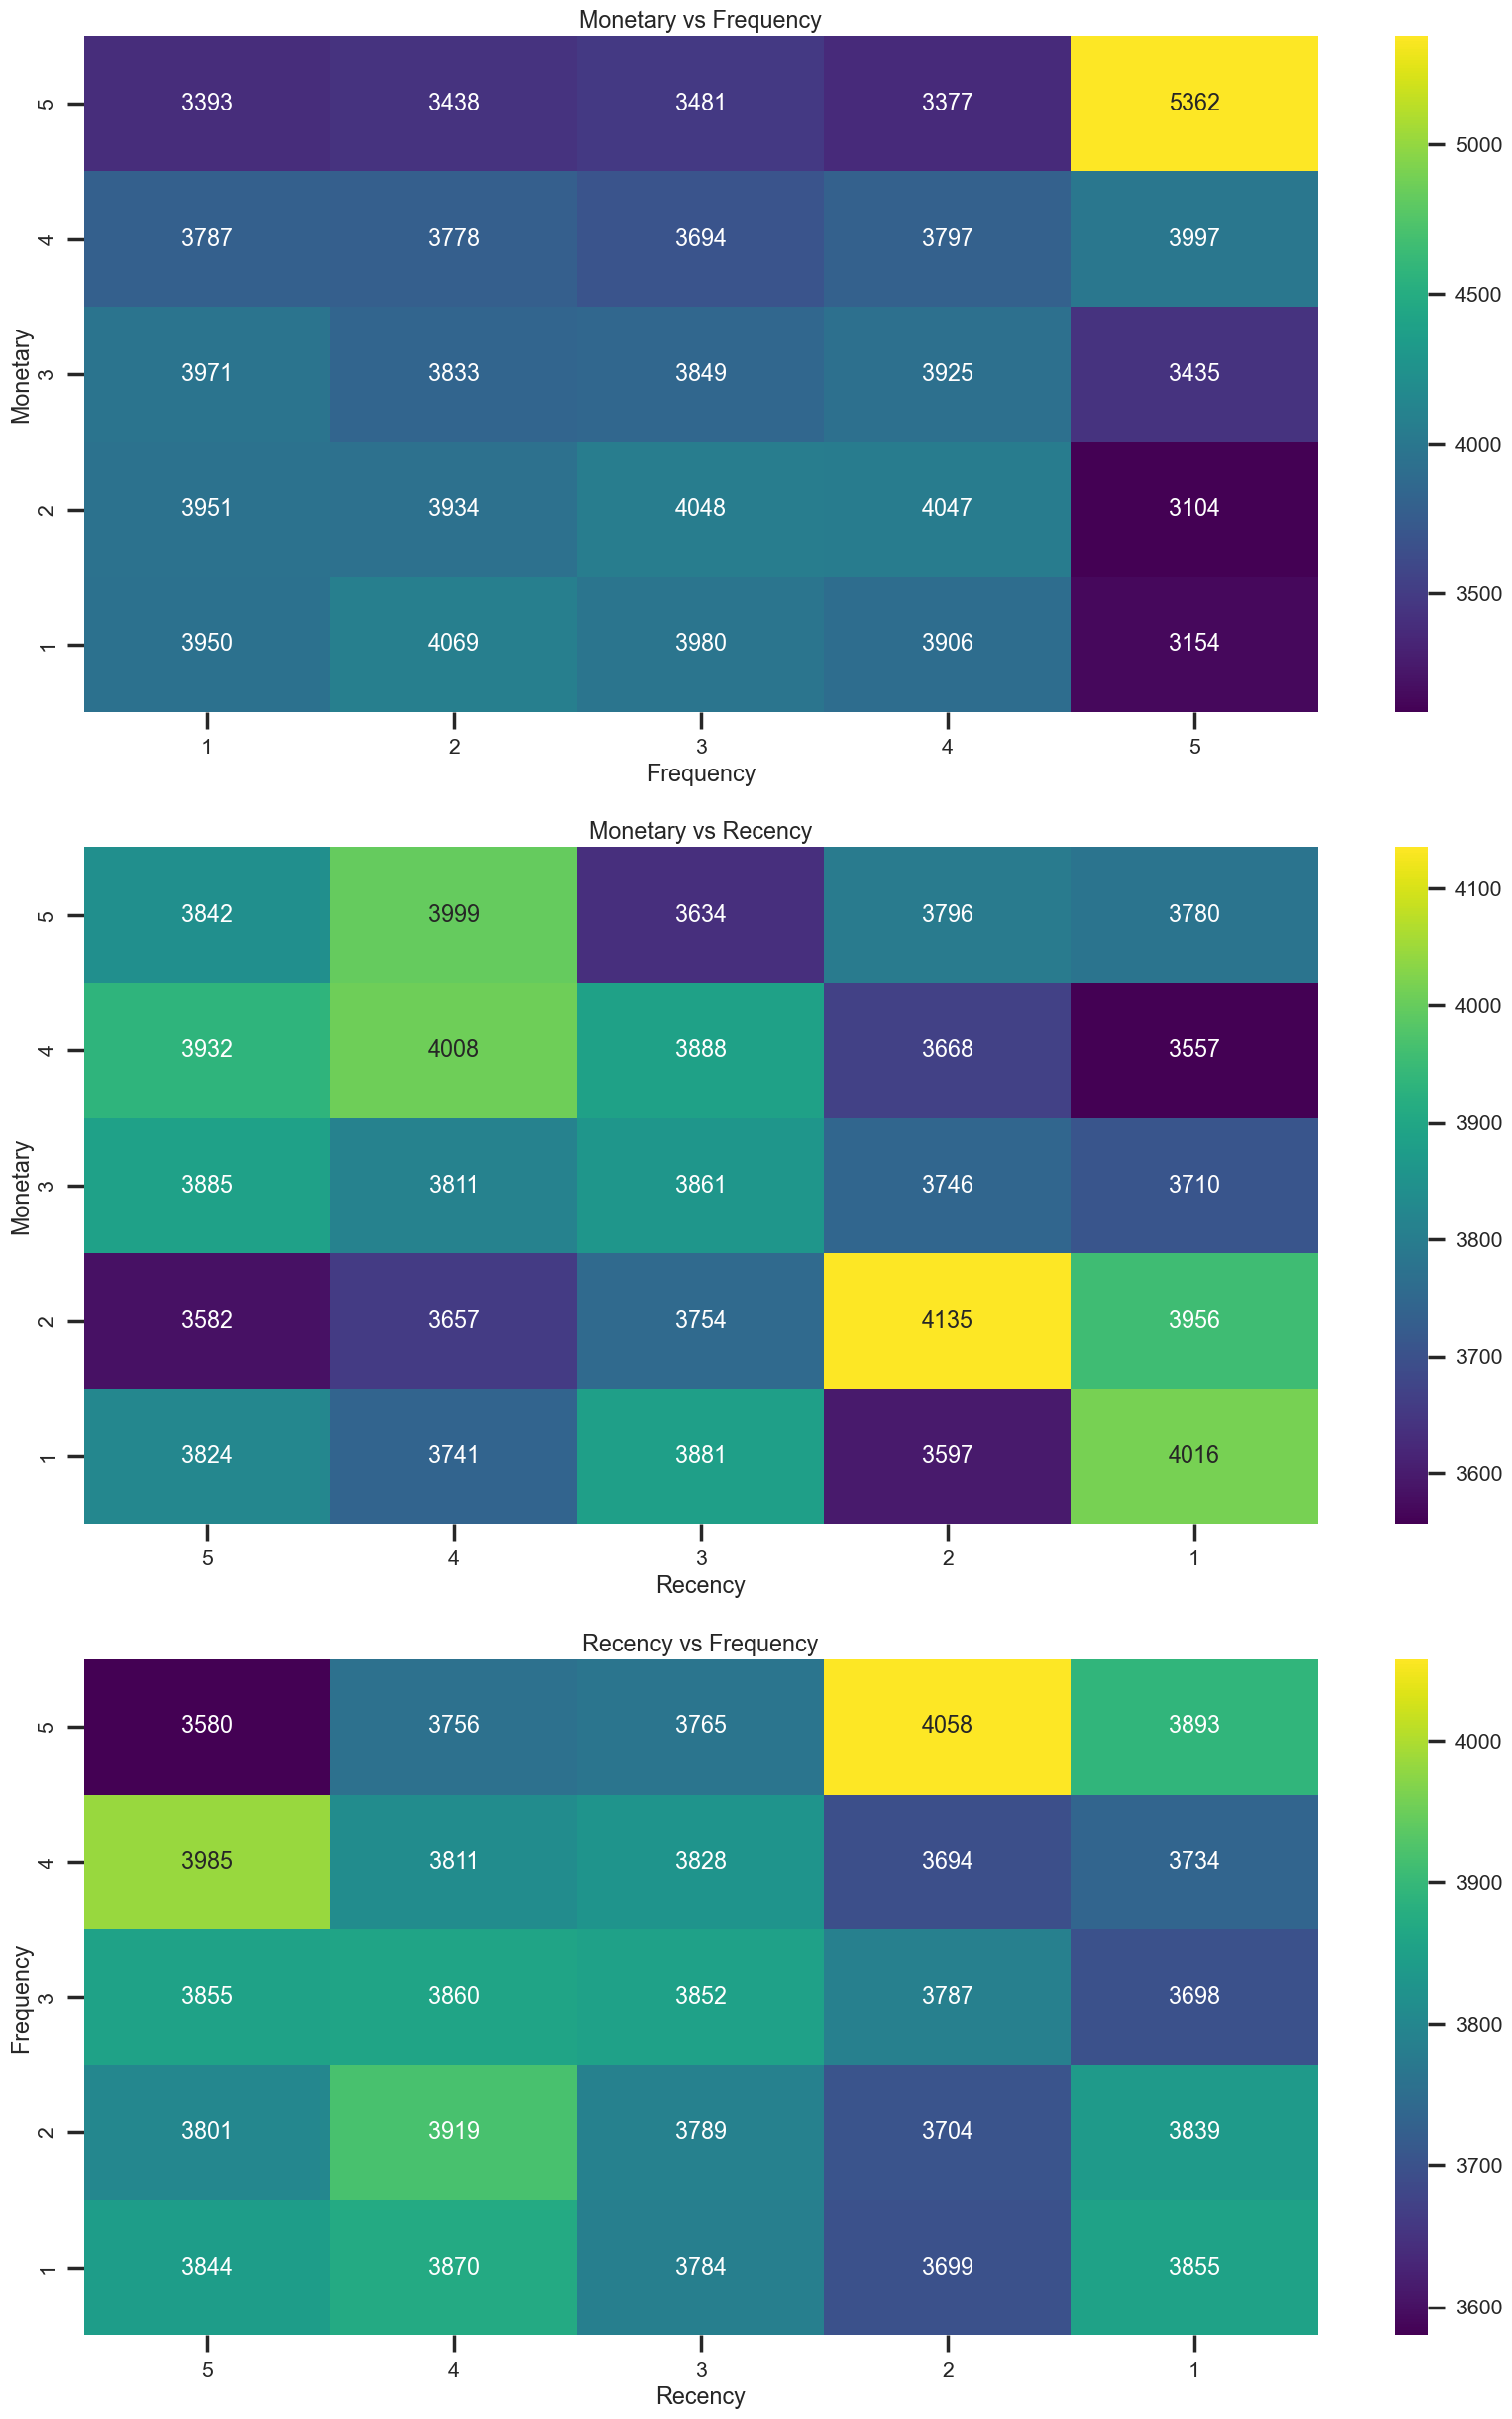

In [70]:
cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

### Segmenting customers based on their levels

In [71]:
bon = rfm[rfm['level'] == 'Bon']
moyen = rfm[rfm['level'] == 'Moyen']
mauvais = rfm[rfm['level'] == 'Mauvais']

#### Checking outliers

#### Outlier treatment for recency


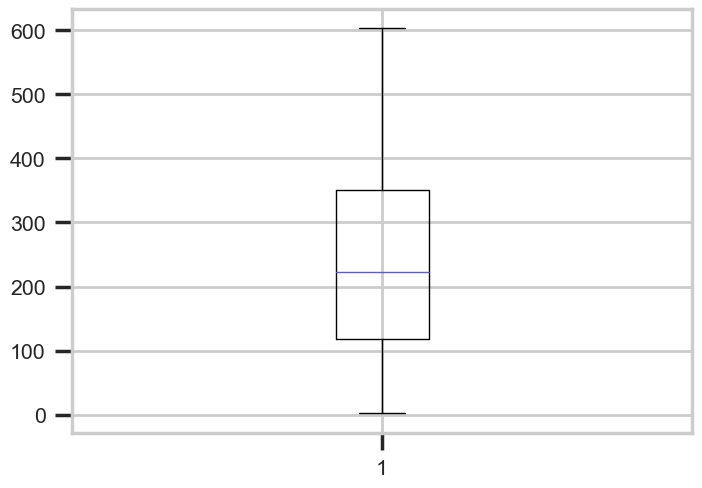

In [72]:
plt.boxplot(rfm.recency)
Q1 = rfm.recency.quantile(0.05)
Q3 = rfm.recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

#### Outlier treatment for frequency

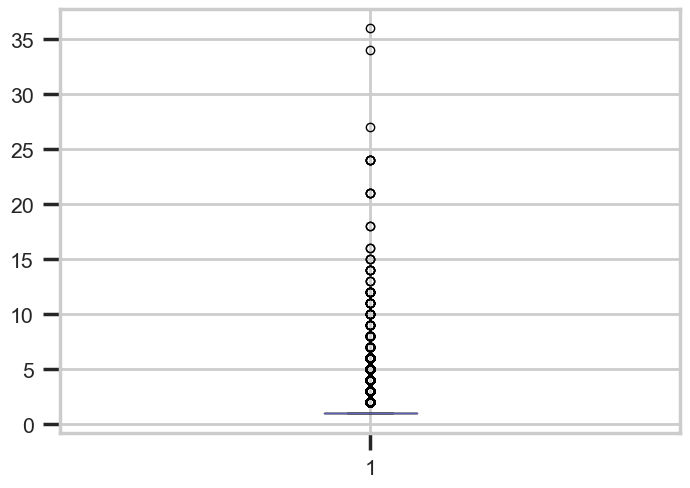

In [73]:
plt.boxplot(rfm.frequency)
Q1 = rfm.frequency.quantile(0.05)
Q3 = rfm.frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

##### Outlier treatment for monetary

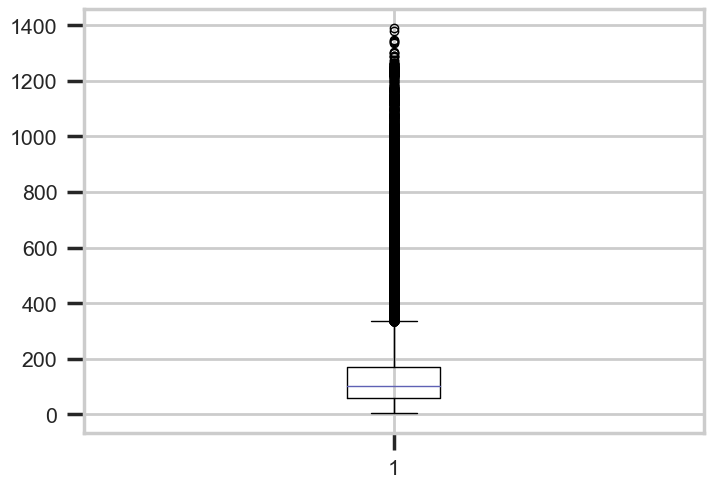

In [74]:
plt.boxplot(rfm.monetary_value)
Q1 = rfm.monetary_value.quantile(0.05)
Q3 = rfm.monetary_value.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary_value >= (Q1 - 1.5*IQR)) & (rfm.monetary_value <= (Q3 + 1.5*IQR))]

## K Means avec les champs numériques

In [103]:
# rfm_t=rfm.copy()

# Sélectionnez les colonnes numériques
rfm_numeric = rfm.select_dtypes(include=[np.number])

# Appliquez la mise à l'échelle standard (StandardScaler) à ces données
scaler_t = StandardScaler()
x_scaled_t=scaler_t.fit(rfm_numeric)
x_scaled_t = scaler_t.fit_transform(rfm_numeric)

# Maintenant, x_scaled contient les données numériques mises à l'échelle

# scaler = StandardScaler()
# x_scaled=scaler.fit(rfm_t)
# x_scaled = scaler.fit_transform(rfm_t)
x_scaled_t

array([[-1.09748364, -0.34952057, -0.78441789, ...,  0.99850517,
         0.40704708, -2.38513741],
       [ 0.87858227, -0.34952057,  0.11868173, ..., -0.42135524,
         0.40704708,  0.01867646],
       [ 0.87858227, -0.34952057, -0.7623561 , ..., -0.51381127,
        -2.0486071 , -1.18323048],
       ...,
       [ 0.87858227, -0.34952057,  0.03139033, ..., -0.52041527,
         0.40704708,  1.62121904],
       [ 0.94098435, -0.34952057,  3.15086321, ..., -1.14119145,
         0.40704708,  2.42249034],
       [-1.01428087, -0.34952057,  0.41289198, ...,  0.20602494,
        -2.0486071 ,  1.2205834 ]])

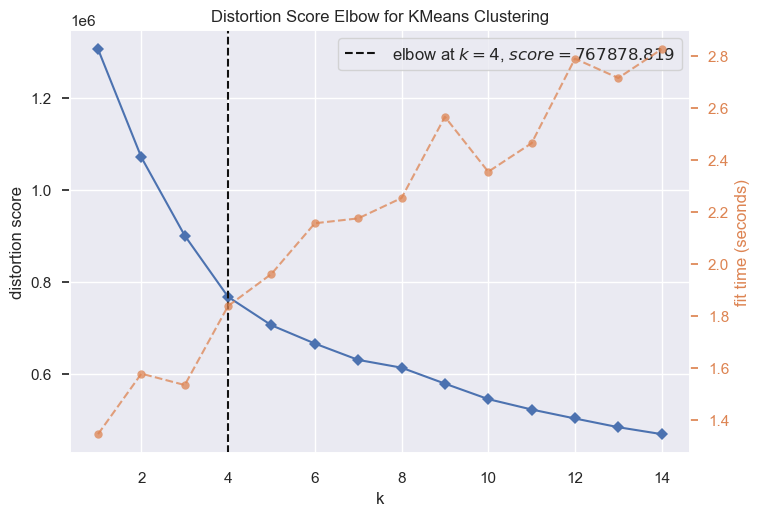

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [119]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15))
visualizer.fit(x_scaled_t)  
visualizer.show()   

In [127]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

rfm_df = rfm.copy()
# Supprimer les lignes avec des valeurs manquantes (NaN)
rfm_df = rfm_df.dropna()

# Remplacer les valeurs infinies par des valeurs finies
rfm_df = rfm_df.replace([np.inf, -np.inf], np.nan)
rfm_df = rfm_df.fillna(rfm_df.mean())

# # Sélectionner les colonnes numériques
# cols = rfm_df.select_dtypes(include=[np.number])
# Sélectionner les colonnes numériques
cols = ['period', 'frequency', 'monetary_value', 'total_dep_by_customer',
       'nb_products_buy', 'volume_product_cm3', 'fav_categ',
       'eval_mean_per_customer', 'nb_of_comment', 'fav_payment_type',
       'satisfaction_client', 'recency', 'Cluster', 'score']
   

# # Vérifiez s'il y a des colonnes non numériques dans rfm_df
# non_numeric_cols = rfm_df.select_dtypes(exclude=[np.number])
# if not non_numeric_cols.empty:
#     print("Colonnes non numériques détectées:", non_numeric_cols.columns)
# numeric_cols_aff = rfm_df.select_dtypes(include=[np.number])    
# if not numeric_cols_aff.empty:
#     print("/nColonnes numériques détectées:", numeric_cols_aff.columns)
    
# Données normalisées
scaler = StandardScaler()
data = scaler.fit_transform(rfm_df[cols])

# Paramètres à tester
param_grid = {
    'n_clusters': [3, 4, 5, 6],  # Différents nombres de clusters à tester
    'init': ['k-means++', 'random'],  # Méthodes d'initialisation
    'max_iter': [100, 200, 300],  # Nombre maximal d'itérations
}

# Créer une instance de KMeans
kmeans = KMeans(random_state=42)

# Créer un objet GridSearchCV pour la recherche d'hyperparamètres
grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring='adjusted_rand_score')

# Adapter le modèle aux données
grid_search.fit(data)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

# Entraîner le modèle KMeans avec les meilleurs paramètres
best_kmeans = KMeans(n_clusters=grid_search.best_params_['n_clusters'],
                     init=grid_search.best_params_['init'],
                     max_iter=grid_search.best_params_['max_iter'],
                     random_state=42)

best_kmeans.fit(data)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

Meilleurs paramètres trouvés :  {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3}


KMeans(max_iter=100, n_clusters=3, random_state=42)

## K Means avec les champs : 'recency','frequency','monetary_value','score'

In [75]:
rfm1=rfm[['recency','frequency','monetary_value','score']]
scaler = StandardScaler()
x_scaled=scaler.fit(rfm1)
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[ 0.99850517, -0.34952057, -0.78441789, -2.38513741],
       [-0.42135524, -0.34952057,  0.11868173,  0.01867646],
       [-0.51381127, -0.34952057, -0.7623561 , -1.18323048],
       ...,
       [-0.52041527, -0.34952057,  0.03139033,  1.62121904],
       [-1.14119145, -0.34952057,  3.15086321,  2.42249034],
       [ 0.20602494, -0.34952057,  0.41289198,  1.2205834 ]])

#### Elbow method

Nous allons **déterminer le nombre de clusters** à l'aide de la méthode Elbow.

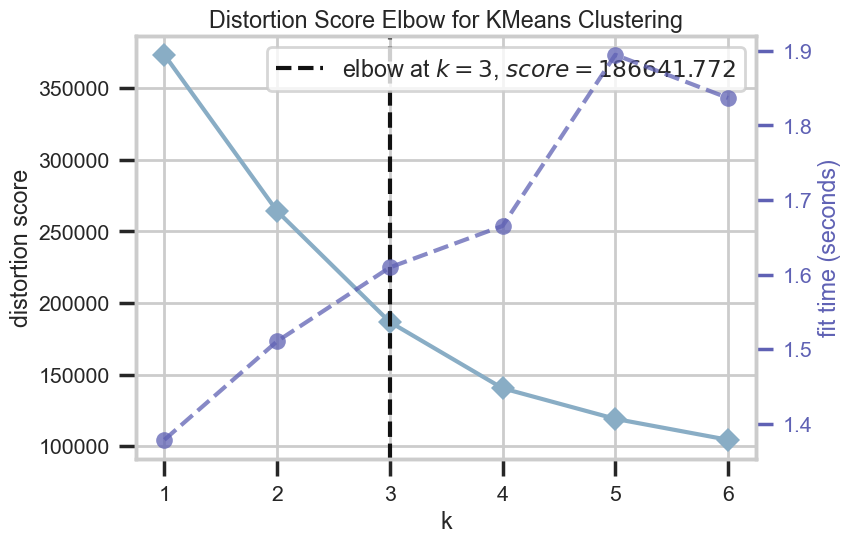

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,7))
visualizer.fit(x_scaled)  
visualizer.show()   

Selon la méthode Elbow, le nombre de clusters est de **3**.

### Recherche du meilleur parametre avec GridSearchCV

In [88]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

rfm_df = rfm.copy()
# Supprimer les lignes avec des valeurs manquantes (NaN)
rfm_df = rfm_df.dropna()

# Remplacer les valeurs infinies par des valeurs finies
rfm_df = rfm_df.replace([np.inf, -np.inf], np.nan)
rfm_df = rfm_df.fillna(rfm_df.mean())

# Sélectionner les colonnes numériques
cols = ['frequency', 'monetary_value','recency']

# Données normalisées
scaler = StandardScaler()
data = scaler.fit_transform(rfm_df[cols])

# Paramètres à tester
param_grid = {
    'n_clusters': [3, 4, 5, 6],  # Différents nombres de clusters à tester
    'init': ['k-means++', 'random'],  # Méthodes d'initialisation
    'max_iter': [100, 200, 300],  # Nombre maximal d'itérations
}

# Créer une instance de KMeans
kmeans = KMeans(random_state=42)

# Créer un objet GridSearchCV pour la recherche d'hyperparamètres
grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring='adjusted_rand_score')

# Adapter le modèle aux données
grid_search.fit(data)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

# Entraîner le modèle KMeans avec les meilleurs paramètres
best_kmeans = KMeans(n_clusters=grid_search.best_params_['n_clusters'],
                     init=grid_search.best_params_['init'],
                     max_iter=grid_search.best_params_['max_iter'],
                     random_state=42)

best_kmeans.fit(data)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-pack

Meilleurs paramètres trouvés :  {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3}


KMeans(max_iter=100, n_clusters=3, random_state=42)

Selon GridSearchCV, le nombre de clusters est de **3**.

### Score silhouette en fonction du nombre de cluster

In [255]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # Créez une liste pour stocker les scores de silhouette
# silhouette_scores = []

# # Essayer différentes valeurs de k (nombre de clusters)
# for k in range(2, 8):
#     model = KMeans(n_clusters=k, random_state=42)
#     labels = model.fit_predict(x_scaled)
#     silhouette_avg = silhouette_score(x_scaled, labels)
#     silhouette_scores.append(silhouette_avg)
#     print(f"Pour k={k}, le score de silhouette moyen est : {silhouette_avg:.3f}")

# # Dans ce code, nous itérons sur différentes valeurs de `k` (nombre de clusters) et calculons le score de silhouette moyen pour chaque valeur de `k`. Le score de silhouette moyen peut prendre des valeurs entre -1 et 1. Un score plus élevé indique que les points sont bien attribués à leurs clusters et que les clusters sont bien séparés.

# # Après avoir exécuté ce code, vous pouvez visualiser les scores de silhouette pour différentes valeurs de `k` et choisir celle qui présente le score le plus élevé, ce qui indique une meilleure séparation entre les clusters. Vous pouvez utiliser la valeur de `k` correspondant au score le plus élevé comme estimation du nombre optimal de clusters.

# # Cependant, gardez à l'esprit que la méthode de la silhouette n'est qu'une méthode d'évaluation parmi d'autres, et il est souvent recommandé d'utiliser plusieurs méthodes en combinaison avec vos connaissances du domaine pour choisir le nombre optimal de clusters.

Pour k=2, le score de silhouette est : 0.302
Pour k=3, le score de silhouette est : 0.357
Pour k=4, le score de silhouette est : 0.382
Pour k=5, le score de silhouette est : 0.316
Pour k=6, le score de silhouette est : 0.324
Pour k=7, le score de silhouette est : 0.327
Pour k=8, le score de silhouette est : 0.305


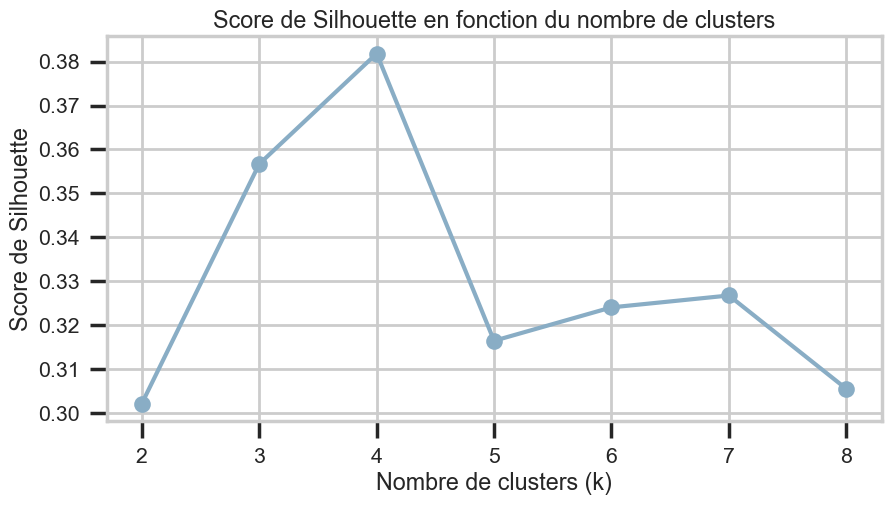

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Liste pour stocker les scores de silhouette
silhouette_scores = []

# Range de k (nombre de clusters) que vous souhaitez tester
k_range = range(2, 9)

# Calculez le score de silhouette pour chaque valeur de k
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(x_scaled)
    silhouette_avg = silhouette_score(x_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# Affichez les scores de silhouette pour chaque k
for k, score in zip(k_range, silhouette_scores):
    print(f"Pour k={k}, le score de silhouette est : {score:.3f}")

# Créez un graphique pour visualiser les scores de silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette en fonction du nombre de clusters')
plt.grid(True)
plt.show()

les scores de silhouette les plus élevés sont observés pour k=3 et k=4, ce qui suggère que ces valeurs de k peuvent être de bons choix pour le nombre de clusters.

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Définir le nombre de répétitions
n_repeats = 10  # Vous pouvez ajuster ce nombre en fonction de vos besoins

# Créer une liste pour stocker les scores de silhouette moyens
silhouette_scores = []

# Répéter le processus de clustering plusieurs fois
for _ in range(n_repeats):
    # Sélectionner un échantillon aléatoire de données
    sample_indices = np.random.choice(len(x_scaled), size=len(x_scaled), replace=True)
    sampled_data = x_scaled[sample_indices]

    # Appliquer K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(sampled_data)
    
    # Calculer le score de silhouette moyen
    silhouette_avg = silhouette_score(sampled_data, labels)
    silhouette_scores.append(silhouette_avg)

# Calculer la moyenne et l'écart-type des scores de silhouette
mean_silhouette = np.mean(silhouette_scores)
std_silhouette = np.std(silhouette_scores)

print(f"Stabilité du Silhouette Score - Moyenne : {mean_silhouette:.3f}")
print(f"Stabilité du Silhouette Score - Écart-type : {std_silhouette:.3f}")


Stabilité du Silhouette Score - Moyenne : 0.306
Stabilité du Silhouette Score - Écart-type : 0.001


1. **Moyenne du Silhouette Score** : Une moyenne du Silhouette Score de 0.328 est généralement considérée comme relativement élevée. Cela indique que, en moyenne, les points d'un cluster sont plus proches les uns des autres que des points d'autres clusters, ce qui est un indicateur positif de la qualité du clustering.

2. **Écart-type du Silhouette Score** : L'écart-type de 0.001 est très faible. Cela signifie que les scores de silhouette obtenus lors de différentes répétitions sont très cohérents, avec peu de variation entre elles. Une faible variation suggère une grande stabilité dans les résultats du clustering.

En combinant ces conclusions, on peut dire que le clustering réalisé avec K-Means semble être stable et cohérent pour vos données. Cela signifie que les clusters obtenus sont robustes et ne dépendent pas fortement de la sélection aléatoire d'échantillons. Les données présentent une structure naturelle qui peut être regroupée de manière cohérente en clusters distincts, avec des points similaires regroupés ensemble et des points de clusters différents étant séparés de manière significative.

Cependant, il est également important de noter que le choix du nombre de clusters (dans ce cas, `k`) peut avoir un impact significatif sur les résultats du clustering. Il peut être judicieux d'explorer différentes valeurs de `k` pour déterminer celle qui maximise la stabilité et l'interprétabilité des clusters dans le contexte de votre application spécifique. Vous pouvez utiliser des méthodes telles que la méthode du coude (Elbow Method) ou le Silhouette Score lui-même pour choisir la meilleure valeur de `k`.

Scores de silhouette pour chaque k : [0.35938278406153357, 0.43529175029777456, 0.4059319200606601, 0.39404674546826896, 0.4196059373050508, 0.40666697814475794, 0.3991538474563392, 0.3960611088117041, 0.40007487131054836, 0.39698907540206213, 0.40207985240806127, 0.4045953335750877, 0.40904433688077696, 0.4078680615748052, 0.41574741094356443]


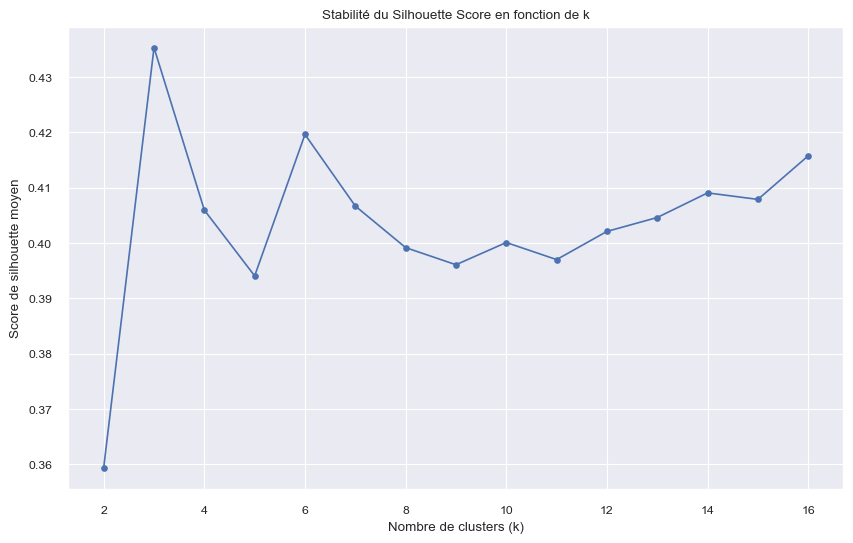

In [238]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Données (remplacez x_scaled par vos données)
x_scaled = np.random.rand(100, 2)

# Créez une liste pour stocker les scores de silhouette moyens
silhouette_scores = []

# Nombre de répétitions pour évaluer la stabilité
n_repeats = 10

# Range de k (nombre de clusters) que vous souhaitez tester
k_range = range(2, 17)

# Liste pour stocker les scores moyens de silhouette pour chaque k
avg_silhouette_scores = []

# Essayer différentes valeurs de k (nombre de clusters)
for k in k_range:
    avg_silhouette = 0
    
    # Répétez le clustering plusieurs fois pour évaluer la stabilité
    for _ in range(n_repeats):
        model = KMeans(n_clusters=k, random_state=np.random.randint(1000))
        labels = model.fit_predict(x_scaled)
        silhouette_avg = silhouette_score(x_scaled, labels)
        avg_silhouette += silhouette_avg
    
    # Calculez la moyenne des scores de silhouette sur les répétitions
    avg_silhouette /= n_repeats
    
    # Ajoutez le score moyen à la liste
    silhouette_scores.append(avg_silhouette)
    avg_silhouette_scores.append(avg_silhouette)

# Affichez les scores de silhouette pour chaque k
print("Scores de silhouette pour chaque k :", silhouette_scores)

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.plot(k_range, avg_silhouette_scores, marker='o', linestyle='-')
plt.title('Stabilité du Silhouette Score en fonction de k')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette moyen')
plt.grid(True)
plt.show()


In [249]:
# from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Générer des données de test
# X, y = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)
# k_max = 5  # Nombre maximum de clusters à tester
# # Fonction pour calculer le Gap Statistic
# def compute_gap(data, k_max):
#     gaps = []
#     for k in range(1, k_max + 1):
#         model = KMeans(n_clusters=k)
#         model.fit(data)
#         intra_cluster_dist = model.inertia_
#         reference_data = np.random.rand(*data.shape)
#         reference_model = KMeans(n_clusters=k)
#         reference_model.fit(reference_data)
#         reference_intra_cluster_dist = reference_model.inertia_
#         gap = np.log(reference_intra_cluster_dist) - np.log(intra_cluster_dist)
#         gaps.append(gap)
#     return gaps

# k_max = 16  # Nombre maximum de clusters à tester
# gap_scores = compute_gap(X, k_max)

# # Afficher les scores Gap
# plt.plot(range(1, k_max + 1), gap_scores)
# plt.xlabel('Nombre de clusters')
# plt.ylabel('Gap Score')
# plt.title('Méthode du Gap Statistic')
# plt.show()


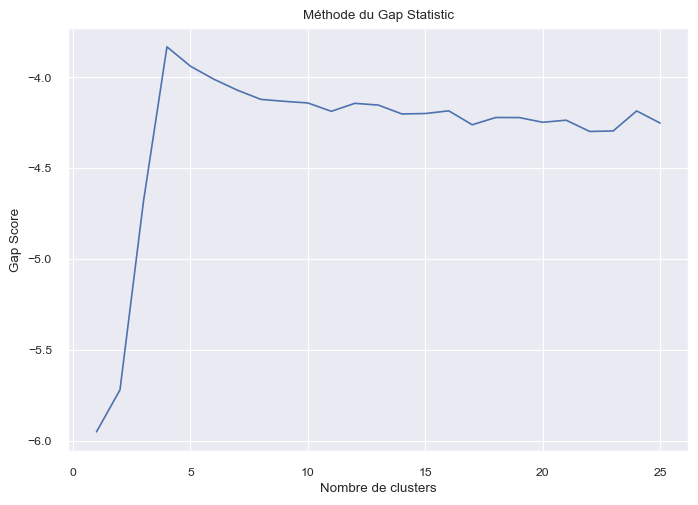

In [248]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Générer des données de test
X, y = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)
# Fonction pour calculer le Gap Statistic
def compute_gap(data, k_max):
    gaps = []
    for k in range(1, k_max + 1):
        model = KMeans(n_clusters=k)
        model.fit(data)
        intra_cluster_dist = model.inertia_
        reference_data = np.random.rand(*data.shape)
        reference_model = KMeans(n_clusters=k)
        reference_model.fit(reference_data)
        reference_intra_cluster_dist = reference_model.inertia_
        gap = np.log(reference_intra_cluster_dist) - np.log(intra_cluster_dist)
        gaps.append(gap)
    return gaps

k_max = 25  # Nombre maximum de clusters à tester
gap_scores = compute_gap(X, k_max)

# Afficher les scores Gap
plt.plot(range(1, k_max + 1), gap_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Gap Score')
plt.title('Méthode du Gap Statistic')
plt.show()


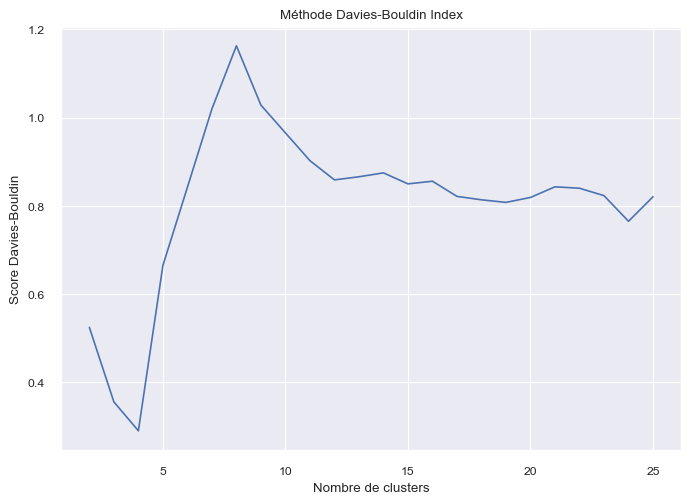

In [257]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import davies_bouldin_score

# Générer des données de test
X, y = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# Calculer le score Davies-Bouldin pour différentes valeurs de k
k_max = 25  # Nombre maximum de clusters à tester
davies_bouldin_scores = []
for k in range(2, k_max + 1):
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X)
    score = davies_bouldin_score(X, labels)
    davies_bouldin_scores.append(score)

# Afficher les scores Davies-Bouldin
plt.plot(range(2, k_max + 1), davies_bouldin_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score Davies-Bouldin')
plt.title('Méthode Davies-Bouldin Index')
plt.show()


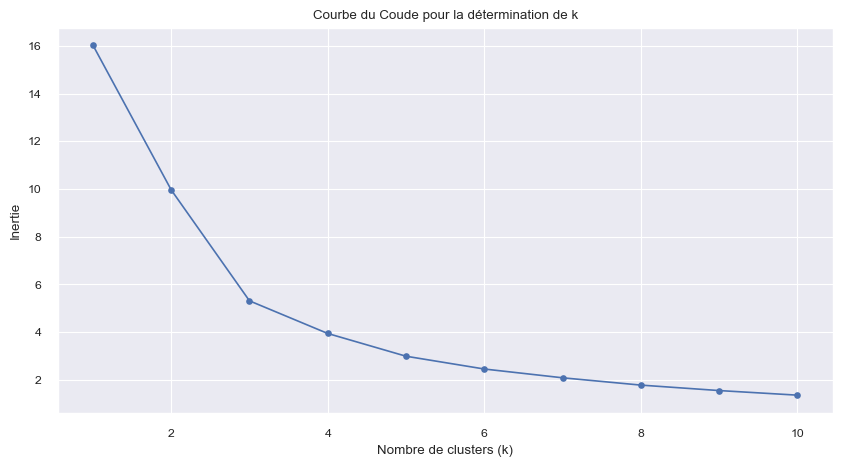

In [258]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Liste pour stocker les valeurs de l'inertie (somme des carrés des distances)
inertia_values = []

# Range de k (nombre de clusters) que vous souhaitez tester
k_range = range(1, 11)

# Calculez l'inertie pour chaque valeur de k
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(x_scaled)
    inertia_values.append(model.inertia_)

# Tracez la courbe du coude
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Courbe du Coude pour la détermination de k')
plt.grid(True)
plt.show()


### Applying K-Means

[1 0 0 ... 0 2 1]
 Our cluster centers are as follows
[[ 0.7693035  -0.34543827 -0.33743205 -0.87669927]
 [-0.68577981 -0.34952057  0.23239773  0.52761778]
 [ 0.03040293  2.57761776  0.25625085  0.96605725]]


recency  frequency  monetary_value  score
cluster_pred                                           
0               38435      38435           38435  38435
1               43776      43776           43776  43776
2               11081      11081           11081  11081

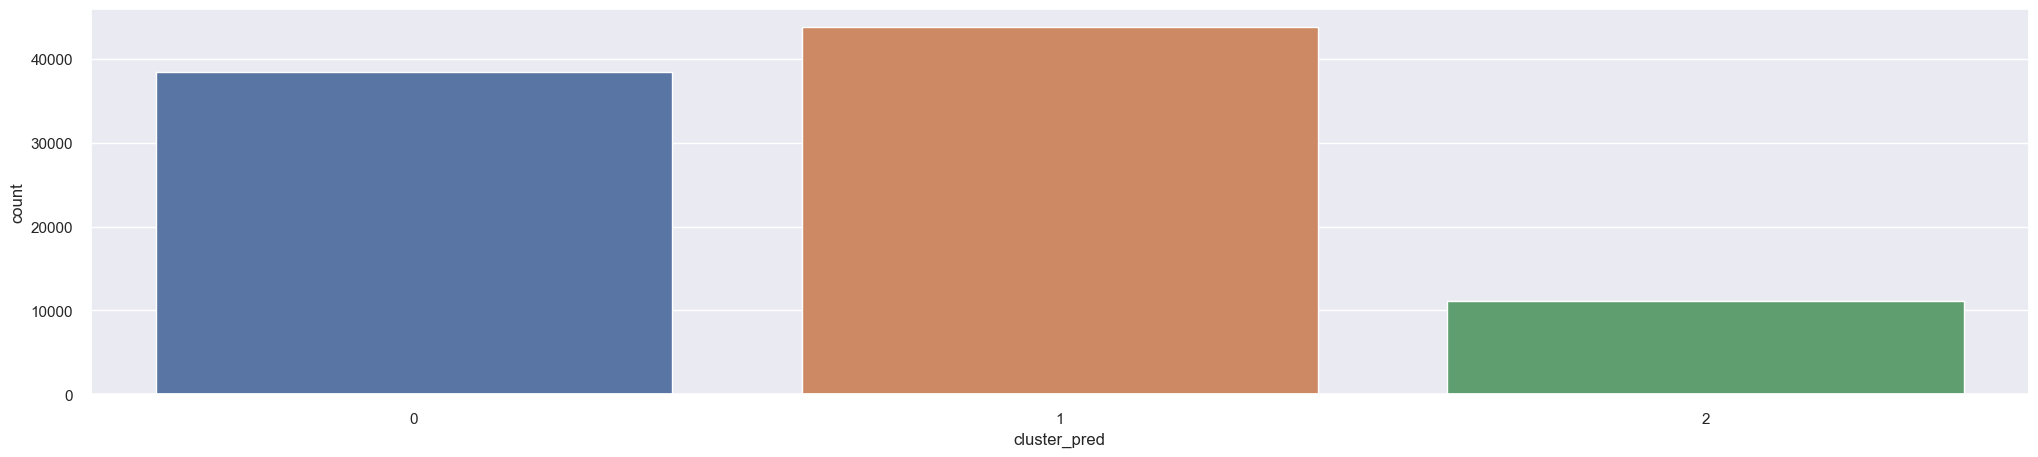

In [87]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

## Diagramme silhouette avec SilhouetteVisualizer

Silhouette Score: 0.357


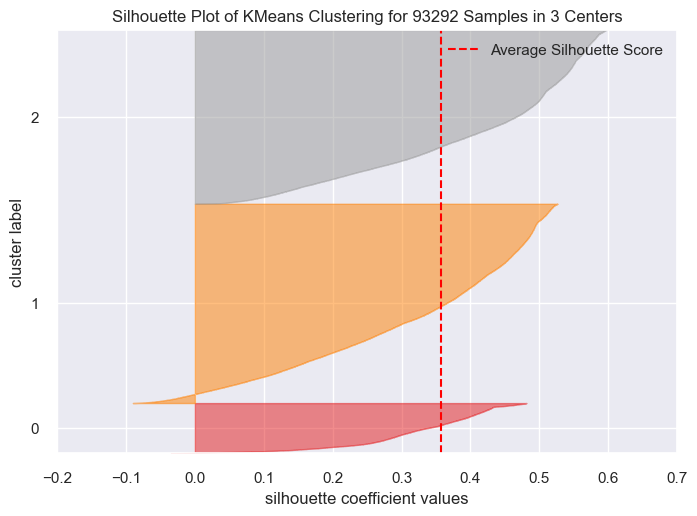

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93292 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [92]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()      

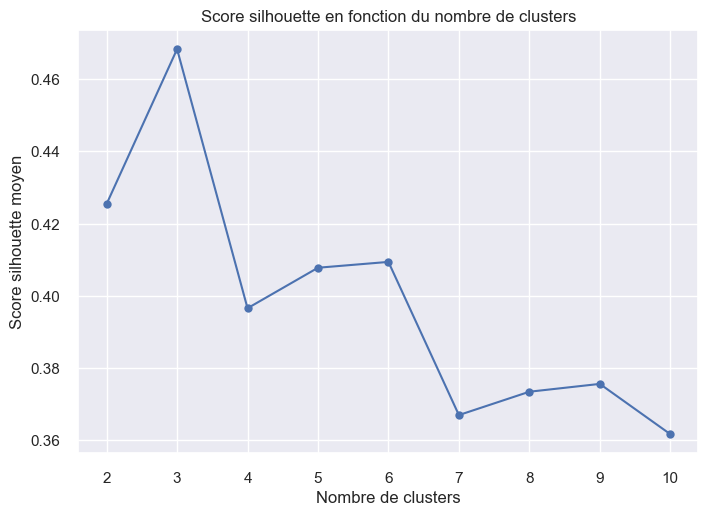

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Liste des valeurs de n_clusters que vous voulez tester
n_clusters_range = range(2, 11)
silhouette_scores = []

for n_clusters in n_clusters_range:
    # Créez un modèle KMeans pour chaque valeur de n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm1)  # X représente vos données
    
    # Calculez le score silhouette pour ce modèle
    silhouette_avg = silhouette_score(rfm1, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracez le graphique des scores silhouette
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score silhouette moyen')
plt.title('Score silhouette en fonction du nombre de clusters')
plt.grid(True)
plt.show()


In [98]:
# from sklearn.metrics import silhouette_score
# from yellowbrick.cluster import SilhouetteVisualizer

# # Créez un modèle KMeans avec le nombre de clusters souhaité
# # model = KMeans(n_clusters=3, random_state=42)

# # Calculez le score de silhouette
# sil_score = silhouette_score(x_scaled, model.labels_, metric='euclidean')
# print('Silhouette Score: %.3f' % sil_score)

# # Créez un visualiseur de silhouette
# visualizer = SilhouetteVisualizer(model)

# visualizer.fit(x_scaled)   
# # Tracez le graphique de silhouette
# visualizer.poof()

# # 
# # model = KMeans(3)
# # visualizer = SilhouetteVisualizer(model)
# # visualizer.fit(x_scaled)   
# # visualizer.poof()      
# # # 

# # Affichez le score de silhouette pour chaque échantillon
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# visualizer.fit(x_scaled)
# visualizer.poof()

# # Tracez un graphique de silhouette pour chaque cluster
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
# visualizer.fit(x_scaled)
# visualizer.poof()

# # Tracez un graphique de silhouette en 3D
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True, ax='3d')
# visualizer.fit(x_scaled)
# visualizer.poof()


In [99]:
# from sklearn.metrics import silhouette_score, silhouette_samples
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.cluster import KMeans

# # Créez un modèle KMeans avec le nombre de clusters souhaité
# model = KMeans(n_clusters=3, random_state=42)

# # Ajustez le modèle à vos données
# model.fit(x_scaled)

# # Obtenez les labels des clusters pour chaque échantillon
# labels = model.labels_

# # Calculez le score de silhouette pour l'ensemble des données
# silhouette_avg = silhouette_score(x_scaled, labels)

# # Calculez le score de silhouette pour chaque échantillon
# sample_silhouette_values = silhouette_samples(x_scaled, labels)

# # Créez un graphique de score silhouette
# fig, ax1 = plt.subplots()
# ax1.set_xlim([-0.1, 1])
# ax1.set_ylim([0, len(x_scaled) + (model.n_clusters + 1) * 10])

# y_lower = 10

# for i in range(model.n_clusters):
#     # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
#     ith_cluster_silhouette_values = \
#         sample_silhouette_values[labels == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = plt.cm.get_cmap("Spectral")(float(i) / model.n_clusters)
#     ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                       0, ith_cluster_silhouette_values,
#                       facecolor=color, edgecolor=color, alpha=0.7)

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples

# ax1.set_xlabel("Score silhouette")
# ax1.set_ylabel("Cluster label")

# # The vertical line for average silhouette score of all the values
# ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# plt.show()


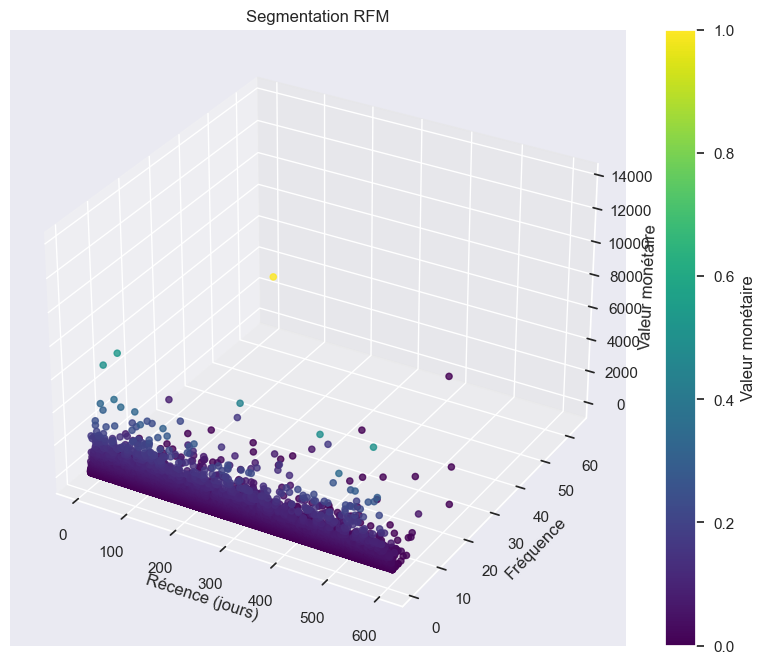

In [101]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Création d'un graphique en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Ajout des points sur le graphique en 3D
# ax.scatter(rfm_df['recency'], rfm_df['frequency'], rfm_df['monetary_value'], c=rfm_df['monetary_value'], cmap='viridis', alpha=0.8)
ax.scatter(rfm_df['recency'], rfm_df['frequency'], rfm_df['monetary_value'], c=rfm_df['monetary_value'], cmap='viridis', alpha=0.8)

# Configuration des axes
ax.set_xlabel('Récence (jours)')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Valeur monétaire')
ax.set_title('Segmentation RFM')

# Ajout de la barre de couleur pour représenter la valeur monétaire
cbar = plt.colorbar(ax.scatter([], [], [], c=[], cmap='viridis'), ax=ax)
cbar.set_label('Valeur monétaire')

plt.show()


Silhouette Score: 0.357


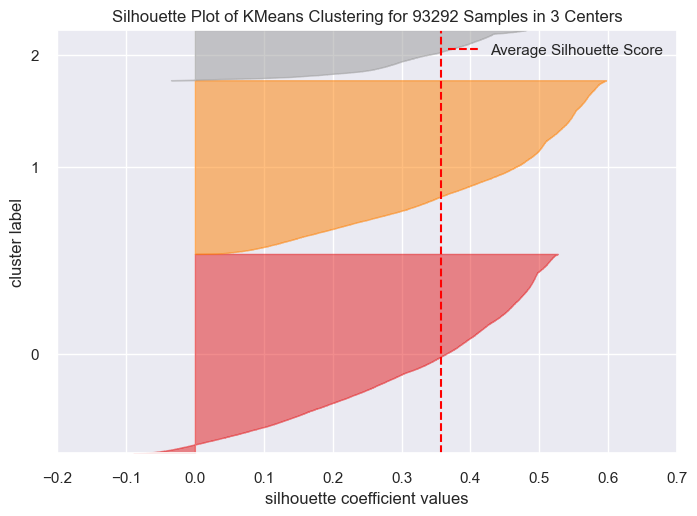

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93292 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [100]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   
    

### Cluster Profiling

We are going to analyse and understand our clusters.

In [369]:
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['level']=rfm['level']

rfm1.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary_value' : ['mean','min','max','count']
})

C:\Users\Zbook\AppData\Local\Temp\ipykernel_5040\3415303891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm1['cluster']= clusters_scaled['cluster_pred']
C:\Users\Zbook\AppData\Local\Temp\ipykernel_5040\3415303891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm1['level']=rfm['level']


recency               frequency           monetary_value          \
               mean    min    max      mean  min  max           mean     min   
cluster                                                                        
0        174.509514    2.0  364.0       1.0  1.0  1.0     750.702755  418.48   
1        260.143119  175.0  364.0       1.0  1.0  1.0     127.488866   10.07   
2         89.349370    2.0  175.0       1.0  1.0  1.0     128.161413    9.59   

                         
             max  count  
cluster                  
0        1512.16   4940  
1         511.20  33287  
2         500.84  33237

En analysant le tableau des statistiques pour chaque cluster, voici ce que l'on peut en déduire :

**Cluster 0 :**
- **Recency (Récence)** : En moyenne, les clients de ce cluster ont effectué leur dernier achat il y a environ 175 jours, avec un minimum de 2 jours et un maximum de 364 jours. Cela suggère que ces clients sont plutôt récents.
- **Frequency (Fréquence)** : Tous les clients de ce cluster ont effectué un seul achat, ce qui signifie qu'ils sont peu fréquents.
- **Monetary Value (Valeur Monétaire)** : La valeur moyenne de leurs achats est assez élevée, autour de 750.70 unités monétaires, avec une variation de 418.48 à 1512.16. Cela suggère que bien que ces clients n'achètent pas souvent, ils dépensent beaucoup lorsqu'ils le font. Le cluster a un total de 4940 membres.

**Cluster 1 :**
- **Recency (Récence)** : Les clients de ce cluster ont effectué leur dernier achat en moyenne il y a environ 260 jours, avec une période minimale de 175 jours et une période maximale de 364 jours. Cela suggère que ces clients sont plutôt anciens.
- **Frequency (Fréquence)** : Tout comme le Cluster 0, tous les clients de ce cluster ont effectué un seul achat, ce qui signifie qu'ils sont peu fréquents.
- **Monetary Value (Valeur Monétaire)** : La valeur moyenne de leurs achats est relativement faible, environ 127.49 unités monétaires, avec une variation de 10.07 à 511.20. Cela suggère que ces clients dépensent moins lors de leurs achats. Le cluster compte un total de 33 287 membres.

**Cluster 2 :**
- **Recency (Récence)** : Les clients de ce cluster ont effectué leur dernier achat en moyenne il y a environ 89 jours, avec une période minimale de 2 jours et une période maximale de 175 jours. Cela suggère que ces clients sont plus récents que ceux du Cluster 1, mais plus anciens que ceux du Cluster 0.
- **Frequency (Fréquence)** : Tout comme les deux autres clusters, tous les clients de ce cluster ont effectué un seul achat, ce qui signifie qu'ils sont peu fréquents.
- **Monetary Value (Valeur Monétaire)** : La valeur moyenne de leurs achats est similaire à celle du Cluster 1, environ 128.16 unités monétaires, avec une variation de 9.59 à 500.84. Cela suggère des dépenses assez faibles. Le cluster compte un total de 33 237 membres.

**Interprétation :**

- Le Cluster 0 représente les clients récents et à forte dépense, bien qu'ils achètent rarement. Ces clients pourraient être des nouveaux clients qui ont effectué des achats importants lors de leur première interaction.

- Le Cluster 1 représente les clients anciens mais à faible dépense. Ils n'ont pas acheté fréquemment et ont généralement dépensé moins lors de leurs achats.

- Le Cluster 2 représente les clients relativement récents avec des dépenses similaires à celles du Cluster 1. Ces clients sont peut-être en train de découvrir votre entreprise et n'ont pas encore dépensé beaucoup.

En utilisant ces informations, vous pourriez personnaliser vos stratégies marketing. Par exemple, pour le Cluster 0, vous pourriez les fidéliser davantage en offrant des promotions spéciales pour les inciter à acheter plus fréquemment. Pour le Cluster 1, vous pourriez envisager des campagnes visant à augmenter leur valeur moyenne d'achat. Pour le Cluster 2, vous pourriez les encourager à acheter plus fréquemment, tout en maintenant leurs dépenses stables.

En se basant sur les informations fournies, voici comment on pourrait associer ces clusters à des groupes de clients :

**Cluster 0 : Clients "Bons"**
- Les clients de ce cluster ont une récence relativement faible, ce qui signifie qu'ils ont acheté récemment.
- Bien qu'ils n'achètent pas fréquemment, ils ont une valeur monétaire élevée à chaque achat, ce qui suggère qu'ils sont prêts à dépenser beaucoup d'argent.
- En raison de leur récence et de leur valeur monétaire élevée, on peut les considérer comme de "Bons" clients, c'est-à-dire qu'ils sont précieux pour l'entreprise.

**Cluster 1 : Clients "Mauvais"**
- Les clients de ce cluster ont une récence élevée, ce qui signifie qu'ils n'ont pas acheté depuis longtemps.
- Ils n'achètent pas fréquemment, et leur valeur monétaire moyenne d'achat est relativement faible.
- En raison de leur récence élevée et de leur faible valeur monétaire, on peut les considérer comme de "Mauvais" clients, car ils n'ont pas montré beaucoup d'intérêt pour les achats récents ni une forte propension à dépenser.

**Cluster 2 : Clients "Moyens"**
- Les clients de ce cluster ont une récence modérée, ce qui signifie qu'ils ont acheté récemment, mais pas aussi récemment que ceux du Cluster 0.
- Comme les deux autres clusters, ils n'achètent pas fréquemment, et leur valeur monétaire moyenne d'achat est similaire à celle du Cluster 1.
- On peut les considérer comme des clients "Moyens", car leur comportement d'achat est intermédiaire entre les "Bons" et les "Mauvais".

Cependant, il est important de noter que ces catégories ("Bons", "Moyens", "Mauvais") sont simplistes et dépendent de la définition spécifique des seuils de récence, de fréquence et de valeur monétaire. Les entreprises peuvent ajuster ces seuils en fonction de leurs besoins et de leurs objectifs marketing.

# Analyse PCA CAH

In [105]:
# Utilisation de .astype(int) pour convertir la colonne en entiers
# df['customer_unique_id'] = df['customer_unique_id'].astype('int64')

In [106]:
# df=pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx")
df = pd.read_csv('data/data_cleaned_rfm.csv')

In [107]:
df['last_order'] = df['last_order'].astype(
    'datetime64')

In [108]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

customer_unique_id  period  last_order  frequency  \
0  baafa8da2de0fd753a885a5c15b11427  201806     81180.0          1   
1  d1588e9ace87e26a010ceb25775113e8  201802     54282.0          1   
2  d34394c17a8b789449feefeb97ac0620  201807     90255.0          1   
3  9136946b6b16453f79f2dfcef449486e  201706     13935.0          1   
4  3105d598604298481a38511105000bdd  201702      2425.0          1   

   monetary_value  total_dep_by_customer  nb_products_buy  volume_product_cm3  \
0          100.35                 100.35                1              7260.0   
1           73.34                  73.34                1             46656.0   
2           47.54                  47.54                1             39600.0   
3           53.33                  53.33                1              3840.0   
4           52.68                  52.68                1              2816.0   

   fav_categ  eval_mean_per_customer  nb_of_comment  fav_payment_type  \
0       12.0                     5.0            0.0               2.0   
1       13.0                     4.0            0.0               1.0   
2       55.0                     5.0            0.0               0.0   
3       45.0                     1.0            1.0               1.0   
4       73.0                     1.0            1.0               0.0   

   satisfaction_client  recency  Cluster recency_score frequency_score  \
0                  1.0       76        1             5               1   
1                  1.0      196        1             3               1   
2                  1.0       31        1             5               1   
3                  0.0      429        2             1               1   
4                  0.0      549        2             1               1   

  monetary_score  score    level  
0              3      9      Bon  
1              2      6    Moyen  
2              1      7    Moyen  
3              2      4    Moyen  
4              1      3  Mauvais

In [109]:
df.set_index('customer_unique_id', inplace=True)

In [110]:
df.dtypes

last_order                              datetime64[ns]
frequency                                      float64
monetary_value                                 float64
review_score                                   float64
satisfaction_status                             object
most_purchased_category                         object
avg_price_in_most_purchased_category           float64
max_comment_length                             float64
delivery_duration                              float64
num_unique_products                            float64
customer_state                                  object
recency                                        float64
mean_monetary_value                            float64
dtype: object

In [111]:
categorical_features = list(df.select_dtypes(exclude=['int32','int64', 'float64', 'uint8']).columns)
categorical_features

['last_order',
 'satisfaction_status',
 'most_purchased_category',
 'customer_state']

In [112]:
data_bis = df.drop(categorical_features ,axis = 1)
data_bis

frequency  monetary_value  review_score  \
customer_unique_id                                                          
0c595173cd5ead1e6c3242781d521c11        1.0           27.23           4.0   
2ee27a6992275f12e9b8320102979055        1.0           42.87           4.0   
7878d477fdfe4911ac5543b953fb4162        1.0          602.88           4.0   
c3c223cb6c2815575f6011ba39740afc        1.0          259.68           5.0   
d37d40917018692928253d2f015ad566        1.0           68.12           5.0   
...                                     ...             ...           ...   
30c9215fbaf3f2ab6b6566f5a32ca75a        1.0           59.09           4.0   
32f151f701410f4f875920ff8b235001        1.0          112.36           5.0   
73b8cd05f8b04f402a513776ed53f5e0        1.0           95.43           4.0   
e9fbafc65ee79ac983dbdf0e2057a07b        1.0           37.58           3.0   
611ec4b5acd5f2b7ada09c9e188b695f        1.0           47.68           5.0   

                                  avg_price_in_most_purchased_category  \
customer_unique_id                                                       
0c595173cd5ead1e6c3242781d521c11                                 17.89   
2ee27a6992275f12e9b8320102979055                                 30.00   
7878d477fdfe4911ac5543b953fb4162                                129.00   
c3c223cb6c2815575f6011ba39740afc                                189.99   
d37d40917018692928253d2f015ad566                                 53.99   
...                                                                ...   
30c9215fbaf3f2ab6b6566f5a32ca75a                                 44.99   
32f151f701410f4f875920ff8b235001                                 79.90   
73b8cd05f8b04f402a513776ed53f5e0                                 79.99   
e9fbafc65ee79ac983dbdf0e2057a07b                                 22.32   
611ec4b5acd5f2b7ada09c9e188b695f                                 39.90   

                                  max_comment_length  delivery_duration  \
customer_unique_id                                                        
0c595173cd5ead1e6c3242781d521c11                 0.0           449137.0   
2ee27a6992275f12e9b8320102979055                 0.0           708330.0   
7878d477fdfe4911ac5543b953fb4162                57.0           504971.0   
c3c223cb6c2815575f6011ba39740afc                15.0          2077291.0   
d37d40917018692928253d2f015ad566                50.0          1143609.0   
...                                              ...                ...   
30c9215fbaf3f2ab6b6566f5a32ca75a               179.0          2084567.0   
32f151f701410f4f875920ff8b235001                 0.0          1374720.0   
73b8cd05f8b04f402a513776ed53f5e0                 0.0           622630.0   
e9fbafc65ee79ac983dbdf0e2057a07b                 0.0          1380079.0   
611ec4b5acd5f2b7ada09c9e188b695f                 0.0           538718.0   

                                  num_unique_products  recency  \
customer_unique_id                                               
0c595173cd5ead1e6c3242781d521c11                  1.0    219.0   
2ee27a6992275f12e9b8320102979055                  1.0     30.0   
7878d477fdfe4911ac5543b953fb4162                  1.0     73.0   
c3c223cb6c2815575f6011ba39740afc                  1.0    322.0   
d37d40917018692928253d2f015ad566                  1.0    293.0   
...                                               ...      ...   
30c9215fbaf3f2ab6b6566f5a32ca75a                  1.0    195.0   
32f151f701410f4f875920ff8b235001                  1.0    135.0   
73b8cd05f8b04f402a513776ed53f5e0                  1.0    134.0   
e9fbafc65ee79ac983dbdf0e2057a07b                  1.0     31.0   
611ec4b5acd5f2b7ada09c9e188b695f                  1.0    240.0   

                                  mean_monetary_value  
customer_unique_id                                     
0c595173cd5ead1e6c3242781d521c11                27.23  
2ee27a6992275f12e9b8320102979055                42.87  
7878d477fd

In [113]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, data_bis)])

In [114]:
X_cah = data_bis.copy()
X_cah.head(10)

frequency  monetary_value  review_score  \
customer_unique_id                                                          
0c595173cd5ead1e6c3242781d521c11        1.0           27.23           4.0   
2ee27a6992275f12e9b8320102979055        1.0           42.87           4.0   
7878d477fdfe4911ac5543b953fb4162        1.0          602.88           4.0   
c3c223cb6c2815575f6011ba39740afc        1.0          259.68           5.0   
d37d40917018692928253d2f015ad566        1.0           68.12           5.0   
c119ea09235d299ed246d52960913d6f        1.0          317.39           5.0   
059ba8400bf965adf606ecc7ef3396e9        1.0          205.26           5.0   
44bd7571a7dad968306f7776bd5a5745        1.0          142.02           4.0   
bb21eb7a7de7d4886dfa152f60505863        1.0           76.51           5.0   
a2c4f621974a8eb173a33890280eb327        1.0           72.45           4.0   

                                  avg_price_in_most_purchased_category  \
customer_unique_id                                                       
0c595173cd5ead1e6c3242781d521c11                                 17.89   
2ee27a6992275f12e9b8320102979055                                 30.00   
7878d477fdfe4911ac5543b953fb4162                                129.00   
c3c223cb6c2815575f6011ba39740afc                                189.99   
d37d40917018692928253d2f015ad566                                 53.99   
c119ea09235d299ed246d52960913d6f                                299.99   
059ba8400bf965adf606ecc7ef3396e9                                185.00   
44bd7571a7dad968306f7776bd5a5745                                124.90   
bb21eb7a7de7d4886dfa152f60505863                                 59.90   
a2c4f621974a8eb173a33890280eb327                                 59.90   

                                  max_comment_length  delivery_duration  \
customer_unique_id                                                        
0c595173cd5ead1e6c3242781d521c11                 0.0           449137.0   
2ee27a6992275f12e9b8320102979055                 0.0           708330.0   
7878d477fdfe4911ac5543b953fb4162                57.0           504971.0   
c3c223cb6c2815575f6011ba39740afc                15.0          2077291.0   
d37d40917018692928253d2f015ad566                50.0          1143609.0   
c119ea09235d299ed246d52960913d6f               197.0           351638.0   
059ba8400bf965adf606ecc7ef3396e9                 0.0          1248652.0   
44bd7571a7dad968306f7776bd5a5745                 0.0           614645.0   
bb21eb7a7de7d4886dfa152f60505863                 0.0           533726.0   
a2c4f621974a8eb173a33890280eb327                84.0           977365.0   

                                  num_unique_products  recency  \
customer_unique_id                                               
0c595173cd5ead1e6c3242781d521c11                  1.0    219.0   
2ee27a6992275f12e9b8320102979055                  1.0     30.0   
7878d477fdfe4911ac5543b953fb4162                  1.0     73.0   
c3c223cb6c2815575f6011ba39740afc                  1.0    322.0   
d37d40917018692928253d2f015ad566                  1.0    293.0   
c119ea09235d299ed246d52960913d6f                  1.0     24.0   
059ba8400bf965adf606ecc7ef3396e9                  1.0    158.0   
44bd7571a7dad968306f7776bd5a5745                  1.0    193.0   
bb21eb7a7de7d4886dfa152f60505863                  1.0     65.0   
a2c4f621974a8eb173a33890280eb327                  1.0    308.0   

                                  mean_monetary_value  
customer_unique_id                                     
0c595173cd5ead1e6c3242781d521c11                27.23  
2ee27a6992275f12e9b8320102979055                42.87  
7878d477fdfe4911ac5543b953fb4162               602.88  
c3c223cb6c2815575f6011ba39740afc               259.68  
d37d40917018692928253d2f015ad566                68.12  
c119ea09235d299ed246d52960913d6f               317.39  
059ba8400bf965adf606ecc7ef3396e9               205.26  
44bd7571a7dad968306f77

In [115]:
# Step 3: Preprocessing the data

X_cah = X_cah.dropna()
# Remplacez les valeurs infinies par des valeurs finies (par exemple, remplacez les valeurs infinies par la moyenne des valeurs non infinies) :

X_cah = X_cah.replace([np.inf, -np.inf], np.nan)
X_cah = X_cah.fillna(df.mean())

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cah)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [116]:
# Explained variance
pca_cah = PCA()
pca_cah.fit(X_normalized)

print(pca_cah.explained_variance_)
print(pca_cah.explained_variance_ratio_)

[2.83255674e-01 2.30655545e-01 1.39589872e-01 1.34522720e-01
 1.04005442e-01 3.30832007e-02 1.64091355e-02 9.42356813e-03
 3.65882932e-05]
[2.97856058e-01 2.42544661e-01 1.46785017e-01 1.41456679e-01
 1.09366392e-01 3.47884708e-02 1.72549427e-02 9.90930496e-03
 3.84742329e-05]


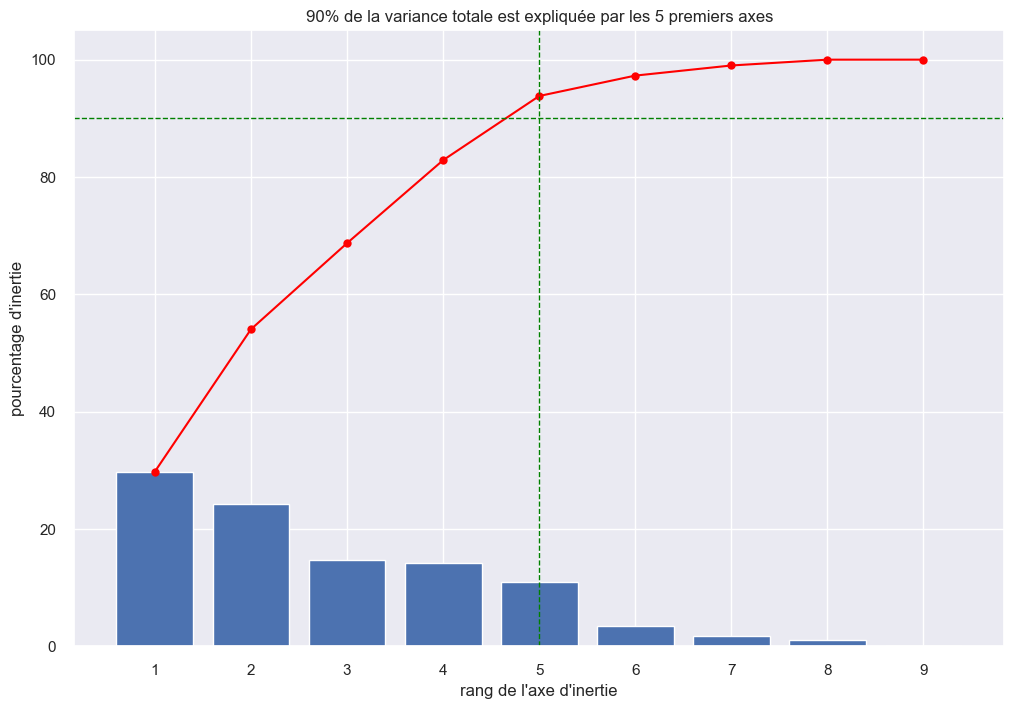

In [117]:
# Explained variance
pca_cah = PCA()
pca_cah.fit(X_normalized)
varexpl = pca_cah.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum() 
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [118]:
# 4 : Réduire la dimensionnalité des Données

pca_cah2 = PCA(n_components = 2)
X_principal = pca_cah2.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [119]:
from sklearn.model_selection import train_test_split

In [120]:
 X_train, X_test,  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

In [393]:
 y_train, y_test,  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

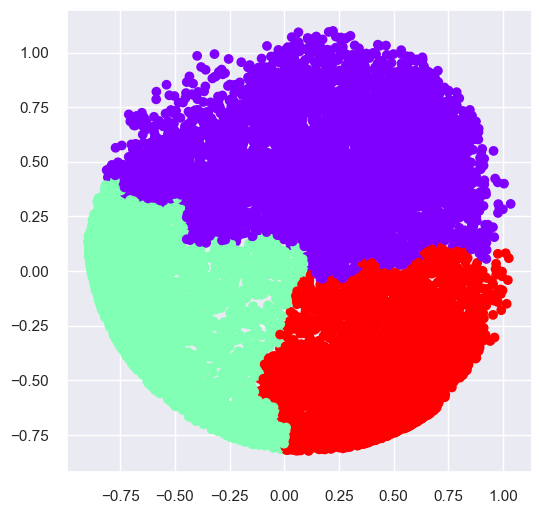

In [395]:

# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac3.fit_predict(y_test), cmap ='rainbow')
plt.show()

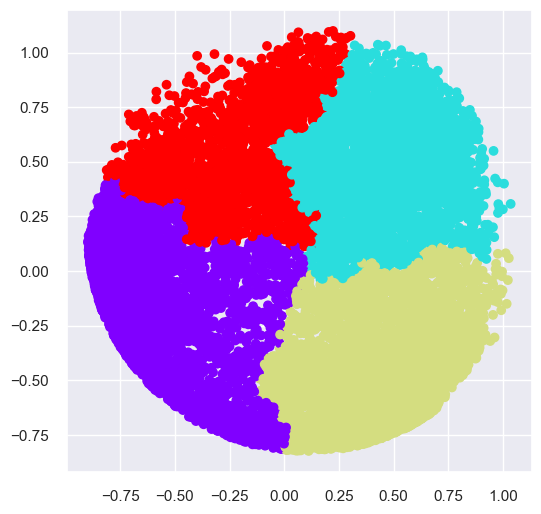

In [396]:

# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac4.fit_predict(y_test), cmap ='rainbow')
plt.show()

### silhouette scores

In [397]:
# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_test, ac2.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac3.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac4.fit_predict(y_test)))

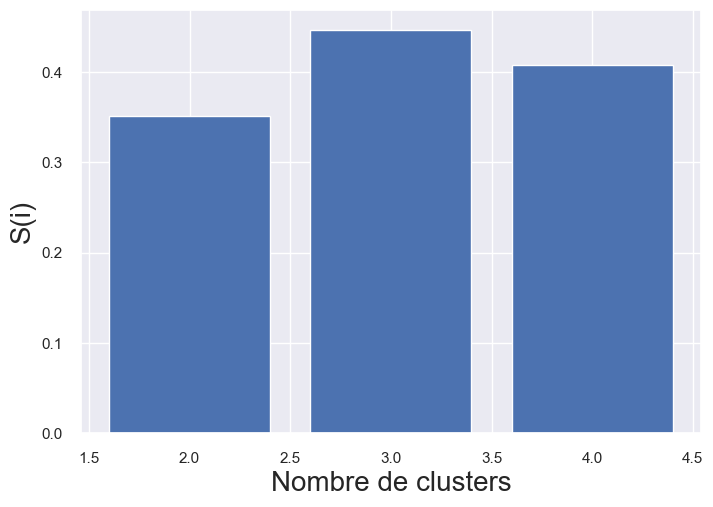

In [398]:
# # Plotting a bar graph to compare the results
# k = [2, 3, 4, 5, 6, 7]
# plt.bar(k, silhouette_scores)
# plt.xlabel('Number of clusters', fontsize = 20)
# plt.ylabel('S(i)', fontsize = 20)
# plt.show()
# Importer les bibliothèques nécessaires
import matplotlib.pyplot as plt

# Liste des nombres de clusters à tester
k = [2, 3, 4]

# Tracer un graphique en barres pour comparer les résultats
plt.bar(k, silhouette_scores)

# Ajouter une étiquette pour l'axe des abscisses (nombre de clusters)
plt.xlabel('Nombre de clusters', fontsize=20)

# Ajouter une étiquette pour l'axe des ordonnées (valeur de S(i) - silhouette_score)
plt.ylabel('S(i)', fontsize=20)

# Afficher le graphique
plt.show()


### dendrogramme

In [399]:
Xbis_train,Xbis_test   = train_test_split(
                     X_normalized,  test_size=0.8, random_state=0)

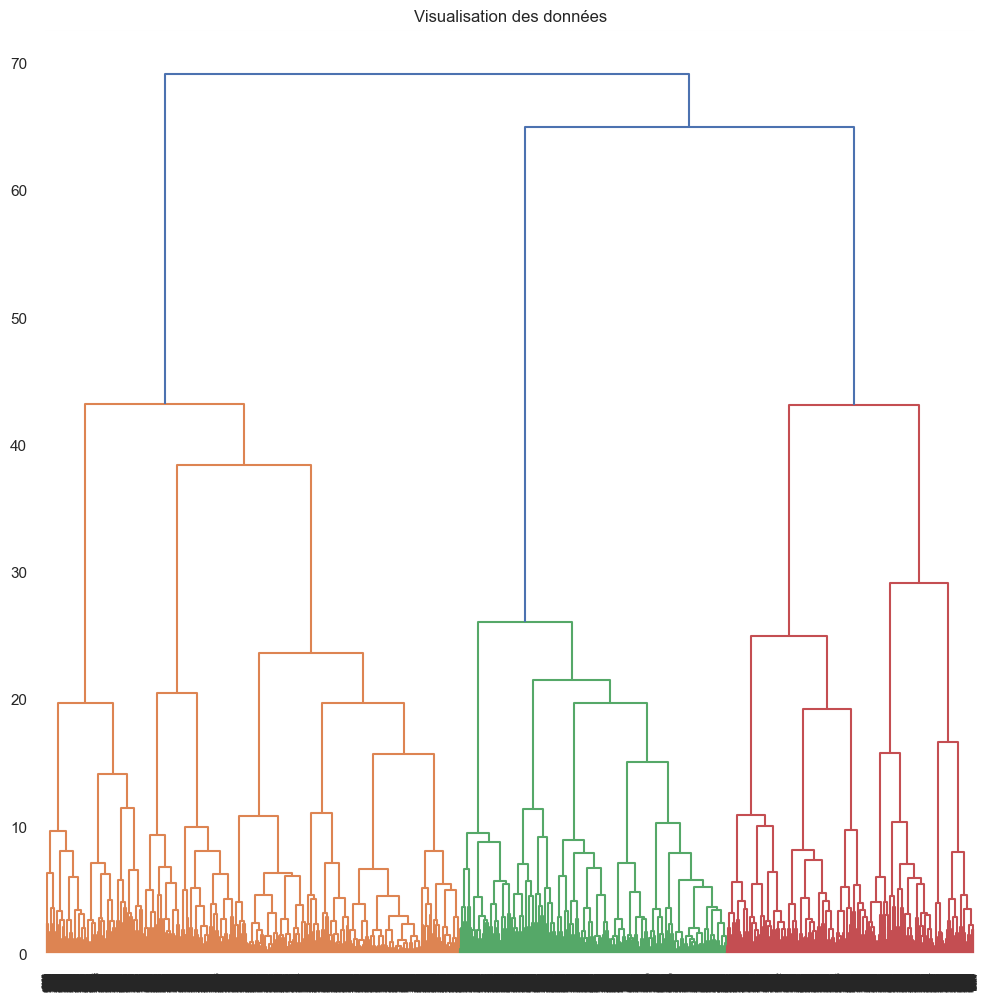

In [400]:
# Créer une figure pour le dendrogramme avec une taille de 12x12 pouces
plt.figure(figsize=(12, 12))

# Donner un titre à la figure
plt.title('Visualisation des données')

# Calculer le dendrogramme à l'aide de la méthode Ward pour la liaison (agglomération) des données
# et le stocker dans la variable 'Dendrogram'
Dendrogram = shc.dendrogram((shc.linkage(Xbis_train, method='ward')))

In [401]:
rfm_df

customer_unique_id  period  last_order  frequency  \
0      0209af58dcd97d6ff5bac3f5fdfb8c0e  201808     90829.0          1   
1      91fd93ada8ac3dabcc95769d269a5900  201706     11178.0          2   
2      30fac3a7d72060742bcbe7b787617343  201802     53136.0          1   
3      07c9259c1afcbd1f6b416d9985782083  201702      1292.0          1   
4      14b24293371e96bdb40f996ad4067cce  201701       442.0          1   
...                                 ...     ...         ...        ...   
96990  9a8ad62bc98119f5b94c149c1eb4c971  201711     37924.0          1   
96991  1d191e1fe1fbad1c0ff0a65fcb6802bb  201702      1984.0          1   
96992  8610d0b6aaf37818de21daf5c7773a79  201802     55424.0          1   
96993  7b03054b90e1c46360273803ece62706  201808     91059.0          1   
96994  de5f37a4f069c0fb5cf92fef24442f0c  201804     65677.0          1   

       monetary_value  total_dep_by_customer  nb_products_buy  \
0              119.53                 119.53                1   
1              113.38                 226.76                2   
2              278.33                 278.33                1   
3             1347.96                1347.96                1   
4              114.77                 114.77                1   
...               ...                    ...              ...   
96990          162.99                 162.99                1   
96991           76.05                  76.05                1   
96992           78.20                  78.20                1   
96993          264.08                 264.08                1   
96994          108.21                 108.21                1   

       volume_product_cm3  fav_categ  eval_mean_per_customer  nb_of_comment  \
0                 27000.0       55.0                     4.0            0.0   
1                  6656.0        0.0                     5.0            0.0   
2                 22528.0       30.0                     2.0            1.0   
3                  7935.0       67.0                     5.0            1.0   
4                  6400.0       63.0                     4.0            0.0   
...                   ...        ...                     ...            ...   
96990             48000.0       14.0                     5.0            1.0   
96991              8712.0       12.0                     1.0            1.0   
96992              4096.0       60.0                     2.0            1.0   
96993             42875.0       63.0                     5.0            1.0   
96994              6498.0       64.0                     5.0            1.0   

       fav_payment_type  satisfaction_client  recency  Cluster  
0                   1.0                  1.0       29        0  
1                   1.0                  1.0      455        0  
2                   1.0                  0.0      201        1  
3                   1.0                  1.0      569        0  
4                   0.0                  1.0      582        0  
...                 ...                  ...      ...      ...  
96990               1.0                  1.0      275        0  
96991               1.0                  0.0      558        1  
96992               1.0                  0.0      191        1  
96993               1.0                  1.0       28        0  
96994               1.0                  1.0      147        0  

[96995 rows x 15 columns]

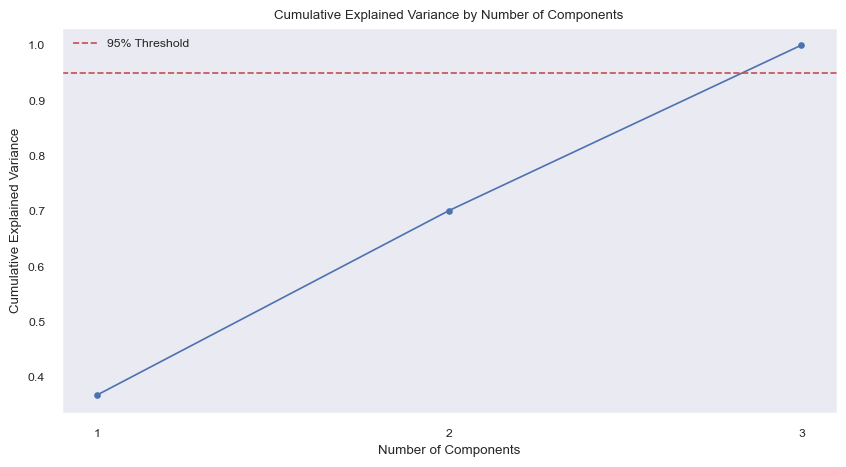

In [216]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Sélectionner les colonnes RFM pour l'ACP
rfm_data = df[['frequency', 'monetary_value', 'recency']]

# Normaliser les données
rfm_scaled = (rfm_data - rfm_data.mean()) / rfm_data.std()

# Appliquer l'ACP
pca = PCA()
pca_result = pca.fit_transform(rfm_scaled)

# Variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

# Graphique pour choisir le nombre de composantes principales
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()


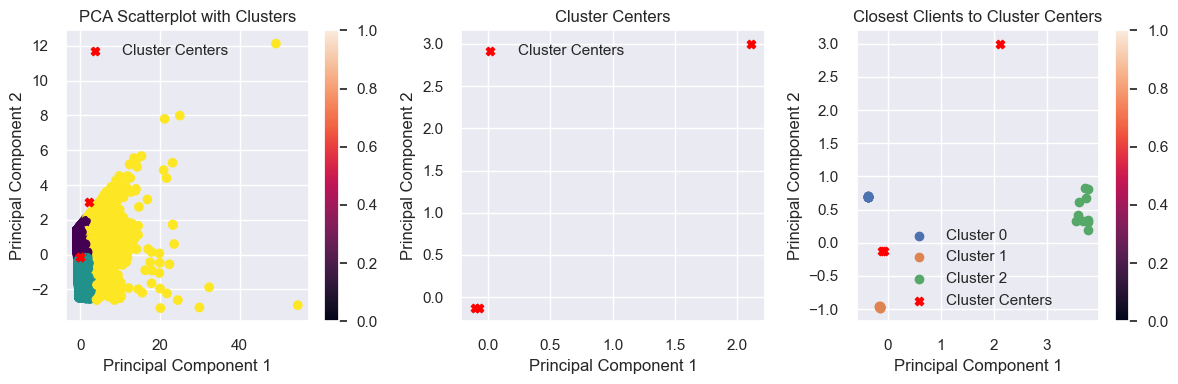

In [424]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Sélectionner les colonnes RFM pour l'ACP
rfm_data = rfm_df[['frequency', 'monetary_value', 'recency']]

# Normaliser les données
rfm_scaled = (rfm_data - rfm_data.mean()) / rfm_data.std()

# Appliquer l'ACP
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Créer un DataFrame pour les composantes principales
pca_df = pd.DataFrame(data=rfm_pca, columns=['PC1', 'PC2'])

# Appliquer KMeans pour créer 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
pca_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Obtenir les centroides
centroids = kmeans.cluster_centers_

# Calculer les distances par rapport aux centroids
distances = np.linalg.norm(rfm_scaled.values - centroids[pca_df['Cluster']], axis=1)
pca_df['centroid_distance'] = distances

# Afficher les scatterplots des composantes principales avec couleurs selon les clusters
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatterplot with Clusters')
plt.legend()
plt.colorbar()

# Afficher les centroides dans le deuxième subplot
plt.subplot(1, 3, 2)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Centers')
plt.legend()

# plt.tight_layout()
# plt.show()

# Afficher les 10 clients les plus proches des centroids de chaque cluster
closest_clients = pca_df.groupby('Cluster').apply(lambda x: x.nsmallest(10, 'centroid_distance'))
# print(closest_clients)
plt.subplot(1, 3, 3)
for cluster in pca_df['Cluster'].unique():
    group = closest_clients[closest_clients['Cluster'] == cluster]
    plt.scatter(group['PC1'], group['PC2'], label=f'Cluster {cluster}')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Closest Clients to Cluster Centers')
plt.legend()
plt.colorbar()

plt.tight_layout()
plt.show()

last_order                              0
frequency                               0
monetary_value                          0
review_score                            0
satisfaction_status                     0
most_purchased_category                 0
avg_price_in_most_purchased_category    0
max_comment_length                      0
delivery_duration                       0
num_unique_products                     0
customer_state                          0
recency                                 0
mean_monetary_value                     0
Cluster                                 0
dtype: int64


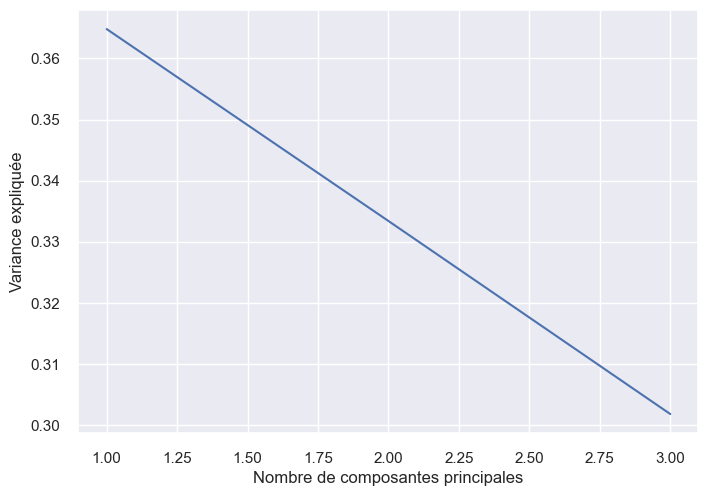

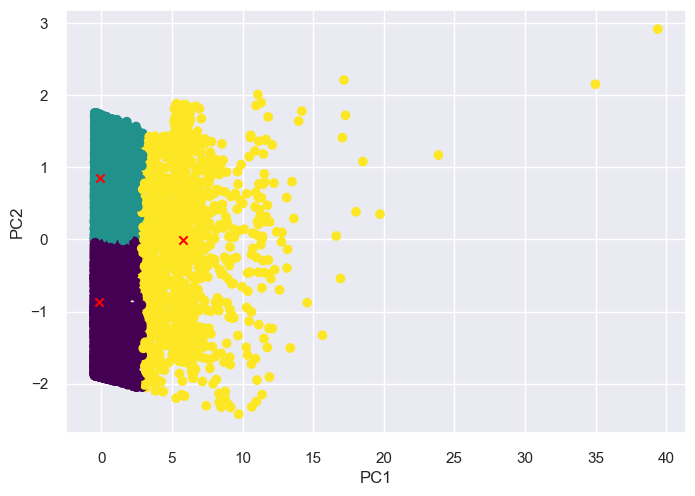

In [423]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# # Charger les données
# df = pd.read_csv('data/data_cleaned_rfm.csv')

# Sélectionner les colonnes numériques
cols = ['frequency', 'monetary_value', 'recency']

# Supprimez les lignes avec des valeurs manquantes (NaN) dans vos données :

df = df.dropna()
# Remplacez les valeurs infinies par des valeurs finies (par exemple, remplacez les valeurs infinies par la moyenne des valeurs non infinies) :

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.mean())
# Vérifiez vos données pour vous assurer qu'il n'y a plus de valeurs manquantes ou infinies :

print(df.isnull().sum())  # Vérifier les valeurs manquantes
# print(np.isinf(df).sum())  # Vérifier les valeurs infinies

# Normaliser les données
scaler = StandardScaler()
data = scaler.fit_transform(df[cols])

# Appliquer la PCR
pca = PCA()
pca.fit(data)
data_pca = pca.transform(data)

# Afficher le graphique des composantes principales
# plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
# plt.xlabel('Nombre de composantes principales')
# plt.ylabel('Variance expliquée')
# plt.show()

# Choisir le nombre de composantes principales à conserver
n_components = 2
data_pca = data_pca[:, :n_components]

# Appliquer l'algorithme k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_pca)
labels = kmeans.labels_

# Ajouter les labels au dataframe
df['Cluster'] = labels

# Créer un graphique de dispersion montrant les clusters
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## T-SNE

utilisons l'algorithme T-SNE pour avoir une idée en première approche du nombre de groupes homogènes

T-SNE (t-Distributed Stochastic Neighbor Embedding) est une technique de réduction de dimension utilisée en apprentissage automatique et en visualisation de données. Son objectif principal est de projeter des données multidimensionnelles dans un espace en deux ou trois dimensions tout en préservant les structures de similarité entre les points.

Résumé :
T-SNE aide à visualiser des données complexes en les réduisant à une dimension inférieure, tout en préservant les relations de similarité entre les points. Cela permet de mieux comprendre la structure et les motifs cachés des données, facilitant ainsi leur analyse et leur interprétation. Il est souvent utilisé pour l'exploration visuelle des données et la détection de groupes ou de clusters.

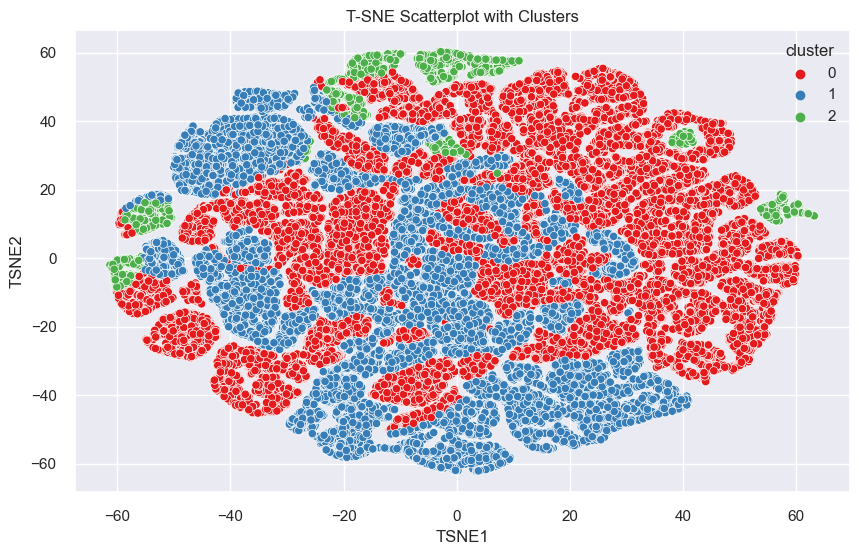

In [428]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# # Charger les données et effectuer les calculs RFM (simplifié pour cet exemple)
# # Charger vos données et effectuer la segmentation
df_sne = pd.read_csv('data/rfm_total.csv')

# Sélectionner les colonnes RFM pour la normalisation
rfm_data = df_sne[['frequency', 'monetary_value', 'recency']]

# Normaliser les données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Utiliser KMeans pour segmenter les clients en clusters
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

# Appliquer T-SNE
tsne = TSNE(n_components=2, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Créer un DataFrame pour les composantes T-SNE
tsne_df = pd.DataFrame(data=rfm_tsne, columns=['TSNE1', 'TSNE2'])

# Ajouter la colonne 'cluster' à tsne_df
tsne_df['cluster'] = rfm_df['cluster']

# Créer un scatterplot des composantes T-SNE en fonction des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='cluster', palette='Set1')
plt.title('T-SNE Scatterplot with Clusters')
plt.show()

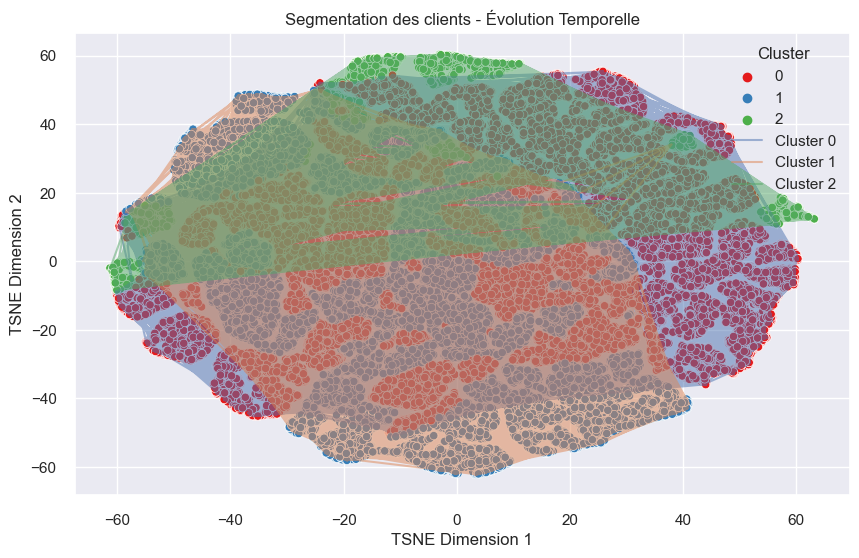

In [436]:
# 8. Évolution Temporelle (si disponible)
# Superposez l'évolution temporelle des clusters à la visualisation T-SNE.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='cluster', palette='Set1')
plt.title('Segmentation des clients - Évolution Temporelle')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')

# Superposez l'évolution temporelle des clusters
for cluster in range(num_clusters):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster]
    plt.plot(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'Cluster {cluster}', alpha=0.5)

plt.legend(title='Cluster')
plt.show()


In [437]:
# 9. Recommandation de la fréquence de mise à jour
# Analysez comment les points se déplacent d'une période à l'autre pour recommander la fréquence de mise à jour.
# cluster_stability = pd.DataFrame(columns=['cluster', 'stability'])
# for cluster in range(num_clusters):
#     stability = calculate_cluster_stability(cluster)
#     cluster_stability = cluster_stability.append({'cluster': cluster, 'stability': stability}, ignore_index=True)
# print("Cluster Stability:")
# print(cluster_stability)

def calculate_cluster_stability(cluster):
    current_cluster = cluster_stability_df[cluster_stability_df['current_cluster'] == cluster]
    previous_cluster = cluster_stability_df[cluster_stability_df['previous_cluster'] == cluster]
    
    common_customers = set(current_cluster['customer_unique_id']).intersection(previous_cluster['customer_unique_id'])
    stability = len(common_customers) / len(current_cluster['customer_unique_id'])
    
    return stability

num_clusters = 3  # Choisissez le nombre de clusters que vous avez utilisé dans K-Means

# Calculer la stabilité de chaque cluster
cluster_stability_df = pd.DataFrame({'customer_unique_id': rfm_df['customer_unique_id'], 'current_cluster': rfm_df['kmeans_cluster']})
cluster_stability_df['previous_cluster'] = cluster_stability_df.groupby('customer_unique_id')['current_cluster'].shift(1)

cluster_stability = pd.DataFrame(columns=['cluster', 'stability'])
for cluster in range(num_clusters):
    stability = calculate_cluster_stability(cluster)
    cluster_stability = cluster_stability.append({'cluster': cluster, 'stability': stability}, ignore_index=True)

print("Stabilité du cluster :")
print(cluster_stability)

Stabilité du cluster :
   cluster  stability
0      0.0   0.020673
1      1.0   0.016791
2      2.0   0.023175


La stabilité du cluster est une mesure qui évalue dans quelle mesure les clients d'un cluster donné restent cohérents ou stables d'une période à l'autre. Plus précisément, elle mesure le pourcentage de clients qui demeurent dans le même cluster par rapport au nombre total de clients dans ce cluster.

Dans votre cas, voici ce que vous pouvez déduire des résultats :

1. **Cluster 0** : La stabilité est d'environ 2%, ce qui signifie que seulement 2% des clients de ce cluster restent dans ce même cluster entre deux périodes. Cela indique une faible stabilité, ce qui peut signifier que ce cluster est moins cohérent au fil du temps.

2. **Cluster 1** : La stabilité est d'environ 1,7%, ce qui est similaire à Cluster 0. Cela suggère également une faible stabilité pour ce cluster.

3. **Cluster 2** : Ce cluster a une stabilité d'environ 2,3%, ce qui est légèrement supérieur aux deux autres clusters mais reste relativement faible.

Globalement, ces résultats indiquent que les clusters que vous avez définis ne sont pas très stables d'une période à l'autre. Cela peut signifier que les clients ont tendance à changer de comportement d'achat au fil du temps, ce qui pourrait nécessiter une mise à jour fréquente des segments de clientèle ou des stratégies de marketing pour mieux répondre à ces variations.

Cependant, il est important de noter que la stabilité seule ne fournit pas toutes les informations nécessaires pour prendre des décisions. Il est également essentiel de considérer d'autres facteurs, tels que les caractéristiques spécifiques des clients dans chaque cluster, pour comprendre pourquoi les changements se produisent et comment y répondre de manière appropriée.

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering utilisé pour regrouper des points de données en fonction de leur densité dans un espace multidimensionnel. Il identifie les régions denses de points et peut détecter les points isolés en tant que valeurs aberrantes (noise).

En résumé, DBSCAN sert à :

1. Identifier des clusters de points de données basés sur leur proximité et leur densité.
2. Gérer efficacement les valeurs aberrantes en les identifiant comme du bruit.
3. Ne pas exiger de spécifier le nombre de clusters à l'avance, ce qui le rend plus flexible que d'autres algorithmes de clustering.

Il est largement utilisé dans divers domaines, tels que l'analyse de données, la vision par ordinateur et l'apprentissage automatique, pour découvrir des structures cachées dans les données.

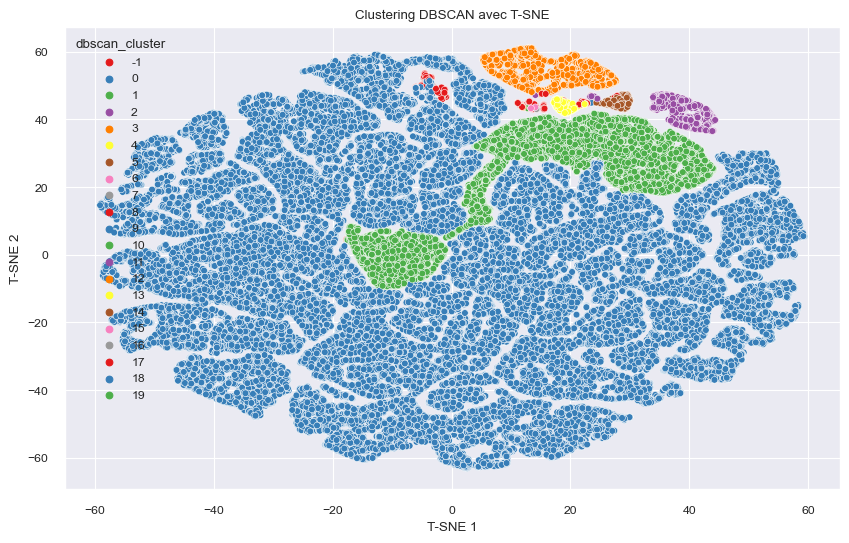

In [231]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que vous ayez déjà le dataframe rfm_df

# Sélectionnez les colonnes RFM pour l'analyse de clustering
rfm_data = rfm_df[['frequency', 'monetary_value', 'recency']]

# Normalisez les données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Appliquez l'algorithme DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm_df['dbscan_cluster'] = dbscan.fit_predict(rfm_scaled)

# Appliquer T-SNE pour visualiser en 2D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Ajoutez les coordonnées T-SNE à votre dataframe
rfm_df['tsne1'] = rfm_tsne[:, 0]
rfm_df['tsne2'] = rfm_tsne[:, 1]

# Visualisez les clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='tsne1', y='tsne2', hue='dbscan_cluster', palette='Set1')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Clustering DBSCAN avec T-SNE')
plt.show()

## Clustering Hiérarchique

Le Clustering Hiérarchique est une technique de regroupement de données qui crée une structure arborescente de clusters, également appelée dendrogramme, en fonction des similitudes entre les données. En résumé, il sert à :

1. Organiser les données en une structure hiérarchique de clusters imbriqués.
2. Permettre une visualisation graphique des relations de similitude entre les données.
3. Ne pas nécessiter de spécification préalable du nombre de clusters.
4. Offrir une compréhension approfondie de la structure des données, en particulier lorsqu'il existe des relations de sous-clusters à différents niveaux.

Cette méthode est couramment utilisée en analyse de données, en biologie pour la classification des espèces, en analyse de texte pour regrouper des documents similaires, et dans d'autres domaines où la structure des données doit être explorée de manière hiérarchique.

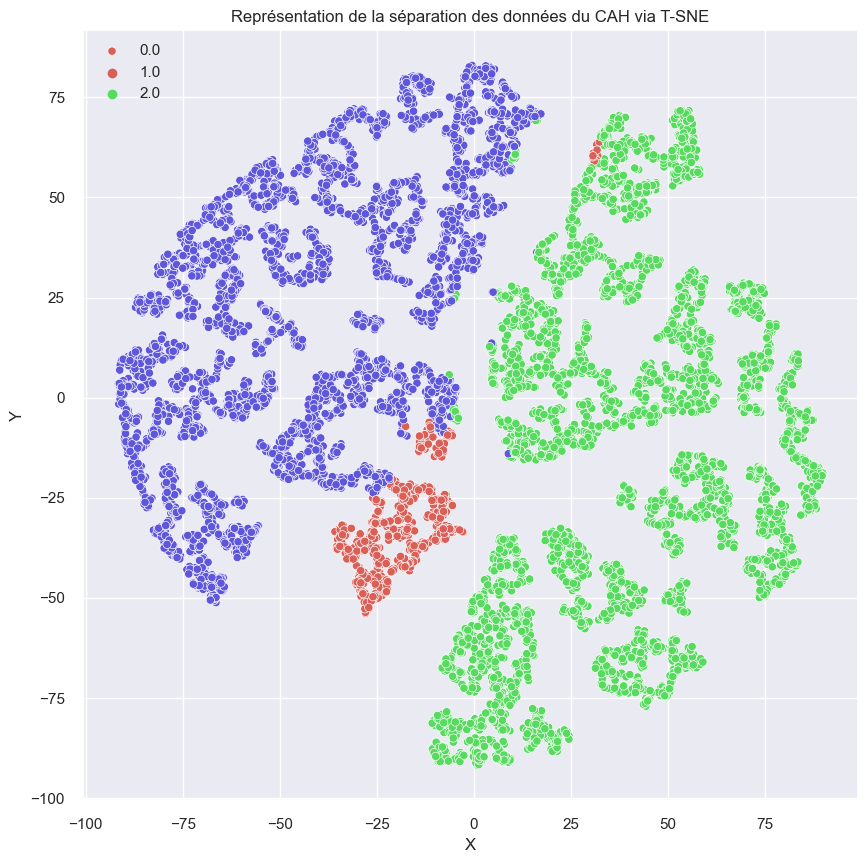

In [447]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des coordonnées T-SNE
tsne = TSNE(n_components=2, random_state=42)
T = tsne.fit_transform(rfm_pca)

# Création du modèle Agglomerative Clustering
nb_clusters_agg = 3  # Nombre de clusters souhaité
cah = AgglomerativeClustering(n_clusters=nb_clusters_agg).fit(rfm_pca.copy())

# # Création du DataFrame graph avec les données T-SNE et les étiquettes de KMeans
# graph = pd.DataFrame(data=[T[:, 0], T[:, 1], kmeans.labels_]).T
# graph.columns = ['X', 'Y', 'label_kmeans']

# # Affichage du graphique avec T-SNE, les étiquettes de CAH et les étiquettes de KMeans
# plt.figure(figsize=(10, 10))
# plt.title('Représentation de la séparation des données du CAH via T-SNE')

# sns.scatterplot(graph['X'], graph['Y'], hue=cah.labels_, legend='full',
#                 palette=sns.color_palette("hls", nb_clusters_agg))

# plt.legend(loc='upper left', labels=graph['label_kmeans'].unique())

# plt.show()

# Création du DataFrame graph avec les données T-SNE et les étiquettes de KMeans
graph = pd.DataFrame(data=[T[:, 0], T[:, 1], cah.labels_]).T
graph.columns = ['X', 'Y', 'label_kmeans']

# Affichage du graphique avec T-SNE, les étiquettes de CAH et les étiquettes de KMeans
plt.figure(figsize=(10, 10))
plt.title('Représentation de la séparation des données du CAH via T-SNE')

sns.scatterplot(graph['X'], graph['Y'], hue=cah.labels_, legend='full',
                palette=sns.color_palette("hls", nb_clusters_agg))

plt.legend(loc='upper left', labels=graph['label_kmeans'].unique())

plt.show()



### Les clients les plus dépensiers

In [459]:
# Trier le dataframe en fonction de la colonne "monetary_value" de manière décroissante
top_spending_customers = rfm_df.sort_values(by='monetary_value', ascending=False)

# Afficher les premières lignes du dataframe pour voir les clients les plus dépensiers
print("Clients les plus dépensiers:")
print(top_spending_customers.head())


In [443]:
# Définissez les seuils pour déterminer les catégories de clients
high_value_threshold = 2000  # Seuil pour les clients importants
low_value_threshold = 500  # Seuil pour les clients moins importants

# Classifiez les clients en trois catégories
rfm_df['customer_category'] = pd.cut(rfm_df['monetary_value'],
                                     bins=[-float("inf"), low_value_threshold, high_value_threshold, float("inf")],
                                     labels=['Mauvais', 'Moyen', 'Importants'])

# Comptez le nombre de clients dans chaque catégorie
customer_category_counts = rfm_df['customer_category'].value_counts()

# Affichez le nombre de clients dans chaque catégorie
print("Nombre de clients importants:", customer_category_counts['Importants'])
print("Nombre de clients moyens:", customer_category_counts['Moyen'])
print("Nombre de clients mauvais:", customer_category_counts['Mauvais'])



Nombre de clients importants: 202
Nombre de clients moyens: 3868
Nombre de clients mauvais: 92925


In [441]:
# 10. Identification des Clients Importants
# Identifiez les clusters qui contiennent les clients les plus importants pour l'entreprise.
threshold_value = 2000  # Définissez le seuil de valeur monétaire pour déterminer les clients importants

important_customers = rfm_df[rfm_df['monetary_value'] > threshold_value]
less_important_customers = rfm_df[rfm_df['monetary_value'] <= threshold_value]

num_important_customers = len(important_customers)
num_less_important_customers = len(less_important_customers)

print("Nombre de clients importants:", num_important_customers)
print("Nombre de clients moins importants:", num_less_important_customers)


Nombre de clients importants: 202
Nombre de clients moins importants: 96793


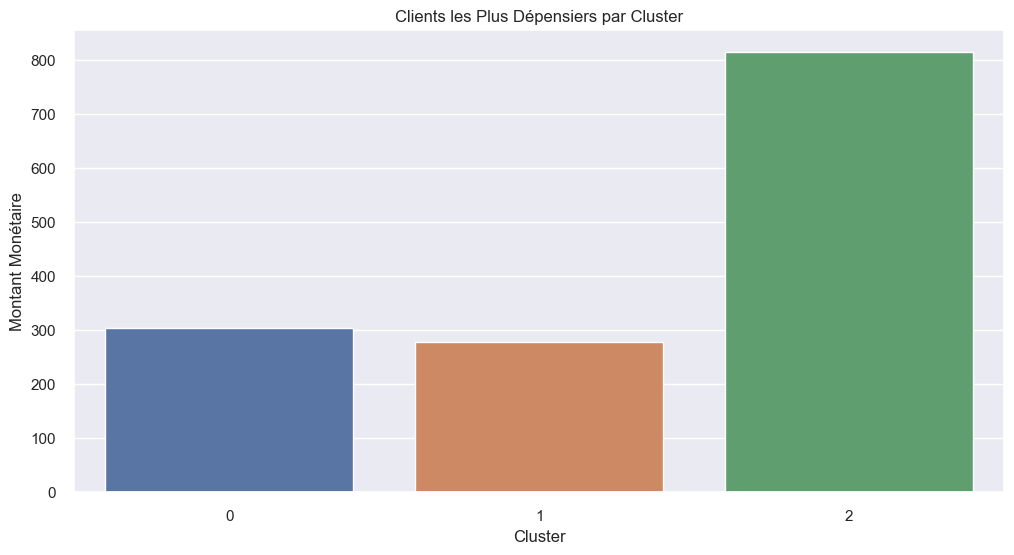

In [450]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que vous avez déjà le dataframe rfm_df avec les colonnes cluster et monetary_value

# Calculez les seuils pour définir les catégories de clients
top_percentile = 0.1  # 10% des clients les plus dépensiers
bottom_percentile = 0.1  # 10% des clients les moins dépensiers

# Trier les clients par montant monétaire dans chaque cluster
rfm_df = rfm_df.sort_values(by=['cluster', 'monetary_value'], ascending=[True, False])

# Définir les seuils pour chaque cluster
top_threshold = int(len(rfm_df) * top_percentile)
bottom_threshold = int(len(rfm_df) * bottom_percentile)

# Sélectionner les clients les plus et les moins dépensiers dans chaque cluster
top_customers = rfm_df.groupby('cluster').head(top_threshold)
bottom_customers = rfm_df.groupby('cluster').tail(bottom_threshold)

# Créer des graphiques pour les clients les plus et les moins dépensiers par cluster
plt.figure(figsize=(12, 6))
sns.barplot(data=top_customers, x='cluster', y='monetary_value', ci=None)
plt.title('Clients les Plus Dépensiers par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Montant Monétaire')
plt.show()

### Les clients les moins dépensiers

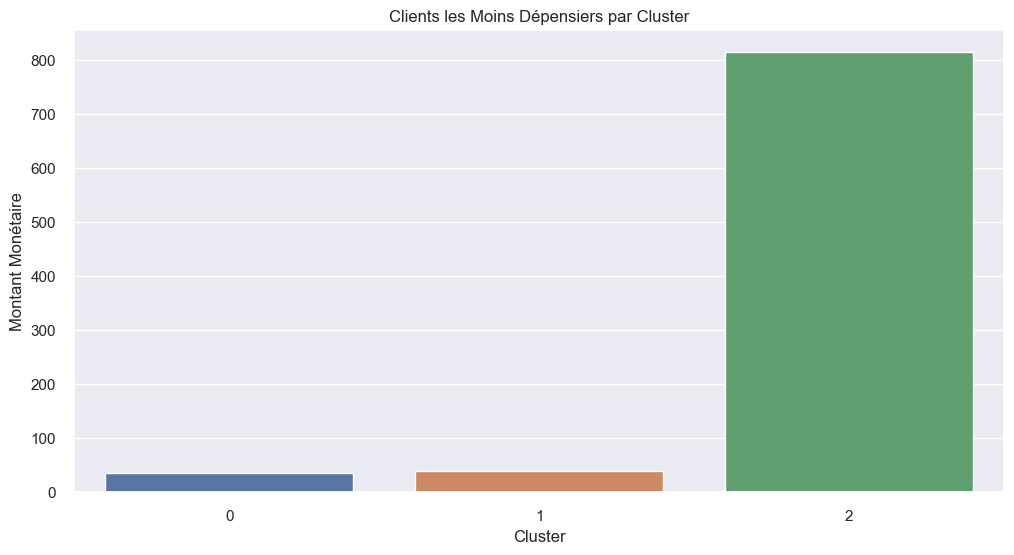

In [451]:
plt.figure(figsize=(12, 6))
sns.barplot(data=bottom_customers, x='cluster', y='monetary_value', ci=None)
plt.title('Clients les Moins Dépensiers par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Montant Monétaire')
plt.show()

### Les clients qui ont acheté le plus grand nombre de produits

In [453]:
rfm_df

customer_unique_id  period  last_order  frequency  \
43815  01ecdc37f767e85f5b3fd2310a289253  201808     94241.0          1   
46168  fcc4e7b7fcfebc7204802b5b797bf993  201808     93343.0          1   
96326  a5c3e82a63848cb08546796194121927  201808     92332.0          1   
83733  918fc1e0f62d6a9c6329dfd85e965e2a  201808     93884.0          1   
76886  f774a1b6de038bc38320ec8751c6df8b  201808     91175.0          1   
...                                 ...     ...         ...        ...   
55561  6bd5b501f37638859ccc1dc94cce730d  201711     33354.0          9   
50272  2bca5fe01d46ab5cc2bc5aaade88d850  201707     17784.0          6   
94377  569aa12b73b5f7edeaa6f2a01603e381  201706     11728.0         26   
5597   2524dcec233c3766f2c2b22f69fd65f4  201712     40049.0         22   
71664  c411c8b6dbaffd467263f87a23f2cf52  201707     14555.0         12   

       monetary_value  total_dep_by_customer  nb_products_buy  \
43815      721.740000                 721.74                1   
46168      718.090000                 718.09                1   
96326      715.340000                 715.34                1   
83733      715.320000                 715.32                1   
76886      714.230000                 714.23                1   
...               ...                    ...              ...   
55561        3.776667                  33.99                9   
50272        3.166667                  19.00                6   
94377        2.410769                  62.68               26   
5597         1.856818                  40.85               22   
71664        1.737500                  20.85               12   

       volume_product_cm3  fav_categ  eval_mean_per_customer  ...  \
43815            131220.0       73.0                     3.0  ...   
46168              4851.0       41.0                     5.0  ...   
96326             23064.0        9.0                     1.0  ...   
83733             42527.0       12.0                     5.0  ...   
76886              3072.0       67.0                     5.0  ...   
...                   ...        ...                     ...  ...   
55561             54000.0       14.0                     5.0  ...   
50272            237600.0       45.0                     5.0  ...   
94377            106496.0       14.0                     5.0  ...   
5597             127072.0       31.0                     5.0  ...   
71664            127500.0       67.0                     4.0  ...   

       fav_payment_type  satisfaction_client  recency  Cluster  cluster  \
43815               1.0                  0.0       17        1        0   
46168               1.0                  1.0       20        0        0   
96326               0.0                  0.0       24        1        0   
83733               1.0                  1.0       18        0        0   
76886               0.0                  1.0       28        0        0   
...                 ...                  ...      ...      ...      ...   
55561               4.0                  1.0      288        2        2   
50272               4.0                  1.0      397        2        2   
94377               4.0                  1.0      450        3        2   
5597                4.0                  1.0      266        3        2   
71664               4.0                  1.0      422        3        2   

       kmeans_cluster  customer_category dbscan_cluster      tsne1      tsne2  
43815               1              Moyen              0 -11.327850  54.512329  
46168               1              Moyen              0 -11.336478  54.444214  
96326               1              Moyen              0 -11.356590  54.378498  
83733               1              Moyen              0 -11.322347  54.409069  
76886               1              Moyen              0 -11.390162  54.330605  
...               ...                ...            ...        ...        ...  
55561               2            Mauvais             -1  60.3

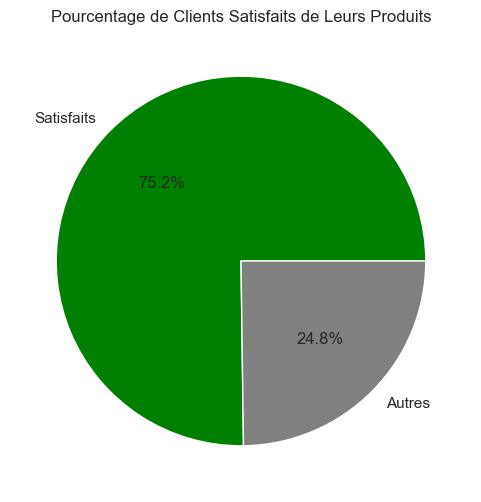

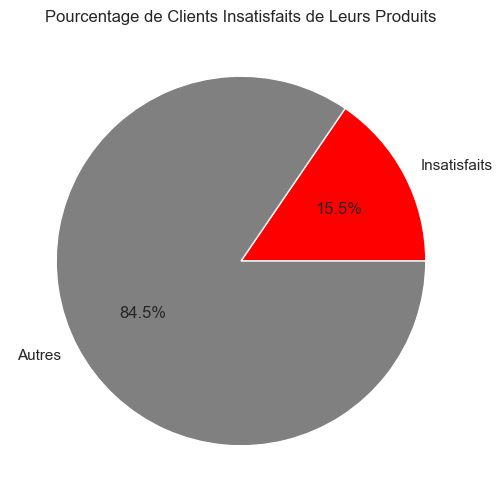

In [460]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
# rfm_df_s = pd.read_csv('data/data_cleaned_rfm.csv')  # Assumer que vous avez déjà calculé et nettoyé les RFM

# Calculer le pourcentage de clients satisfaits et insatisfaits
num_customers = len(rfm_df_s)
num_satisfied = rfm_df_s[rfm_df_s['review_score'] >= 4]['customer_unique_id'].nunique()
num_unsatisfied = rfm_df_s[rfm_df_s['review_score'] <= 2]['customer_unique_id'].nunique()

# Créer un graphique pour le pourcentage de clients satisfaits
plt.figure(figsize=(6, 6))
plt.pie([num_satisfied, num_customers - num_satisfied], labels=['Satisfaits', 'Autres'], autopct='%1.1f%%', colors=['green', 'gray'])
plt.title('Pourcentage de Clients Satisfaits de Leurs Produits')
plt.show()

# Créer un graphique pour le pourcentage de clients insatisfaits
plt.figure(figsize=(6, 6))
plt.pie([num_unsatisfied, num_customers - num_unsatisfied], labels=['Insatisfaits', 'Autres'], autopct='%1.1f%%', colors=['red', 'gray'])
plt.title('Pourcentage de Clients Insatisfaits de Leurs Produits')
plt.show()


In [461]:
from sklearn.cluster import KMeans

rfm = rfm_df_s.copy()
# Sélection des caractéristiques pour le clustering
# features_for_clustering = ['recency', 'frequency', 'monetary_value', 'max_comment_length', 'delivery_duration']
features_for_clustering = ['recency', 'frequency', 'monetary_value']

# Création du modèle de clustering
num_clusters = 3  # Nombre de clusters que vous souhaitez créer
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle sur les caractéristiques sélectionnées
rfm['cluster'] = kmeans.fit_predict(rfm[features_for_clustering])


Pour décrire les clients en fonction des clusters formés par le modèle de clustering, vous pouvez utiliser les centroids de chaque cluster pour définir différents groupes de clients. Voici comment vous pourriez le faire :

1. **Les Bons Clients** : Ce sont ceux qui ont les valeurs les plus élevées pour les caractéristiques associées à un bon comportement d'achat (par exemple, recency faible, frequency élevée, monetary élevée, etc.).

2. **Clients Moyens** : Ce sont ceux qui ont des valeurs proches de la moyenne pour la plupart des caractéristiques.

3. **Mauvais Clients** : Ce sont ceux qui ont des valeurs inférieures à la moyenne pour la plupart des caractéristiques.

Voici comment vous pourriez le mettre en œuvre en Python en utilisant les centroids calculés à partir de votre modèle de clustering (assurez-vous que vous avez déjà effectué le clustering et ajouté la colonne 'cluster' au DataFrame) :


Quant à la mise à jour du modèle de clustering et à la courbe de score ARI (Adjusted Rand Index) avec des données T+n mois, cela implique de re-entraîner votre modèle de clustering sur de nouvelles données et de comparer les résultats avec les clusters précédents. Vous pouvez réaliser cela en utilisant un processus itératif en augmentant progressivement la période de données pour l'entraînement et la période pour les tests.

Pour créer la courbe de score ARI, vous devrez comparer les clusters prédits par le modèle mis à jour avec les clusters prédits précédemment et calculer l'ARI pour chaque itération. Voici comment vous pourriez l'approcher :


In [466]:
# Convertir la colonne 'last_order' en datetime
rfm['last_order'] = pd.to_datetime(rfm['last_order'])


Cette courbe de score ARI vous montrera comment la performance de votre modèle de clustering évolue au fil du temps à mesure que vous mettez à jour les données d'entraînement et de test.

Mauvais    62421
Moyen      30937
Bon         3637
Name: Client_Type, dtype: int64


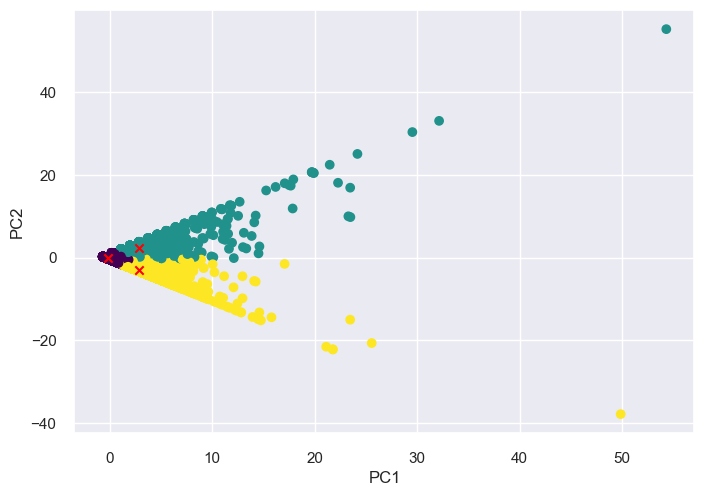

In [471]:
import pandas as pd
import numpy as np  # Assurez-vous d'importer également numpy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger les données
df1 = pd.read_csv('data/rfm_total.csv')

# Sélectionner les colonnes numériques
cols = [ 'frequency', 'monetary_value']

# Supprimer les lignes avec des valeurs manquantes (NaN) dans les données
df1 = df1.dropna()

# Remplacer les valeurs infinies par des valeurs finies (remplacement par la moyenne)
df1 = df1.replace([np.inf, -np.inf], np.nan)
df1 = df1.fillna(df1.mean())  # Remplacez df par df1 ici

# Normaliser les données
scaler = StandardScaler()
data = scaler.fit_transform(df1[cols])  # Remplacez df par df1 ici

# Appliquer l'Analyse en Composantes Principales (PCA)
pca = PCA()
pca.fit(data)
data_pca = pca.transform(data)

# Choisir le nombre de composantes principales à conserver
n_components = 2
data_pca = data_pca[:, :n_components]

# Appliquer l'algorithme K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_pca)
labels = kmeans.labels_

# Ajouter les labels de cluster au dataframe
df1['Cluster'] = labels  # Remplacez df par df1 ici

# Calculer les centroïdes des clusters
cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cols)

# # Associer chaque cluster à un type de client
# def get_client_type(row):
#     cluster_id = row['Cluster']
#     centroid = cluster_centroids.iloc[cluster_id]
    
#     # Comparer les valeurs du client avec les valeurs du centroïde
#     if row['frequency'] >= centroid['frequency'] and row['monetary_value'] >= centroid['monetary_value']:
#         return 'Meilleur'
#     elif row['frequency'] < centroid['frequency'] and row['monetary_value'] < centroid['monetary_value']:
#         return 'Mauvais'
#     elif row['frequency'] >= centroid['frequency'] and row['monetary_value'] < centroid['monetary_value']:
#         return 'Moyen'
#     else:
#         return 'Bon'
# Associer chaque cluster à un type de client
def get_client_type(row):
    cluster_id = row['Cluster']
    centroid = cluster_centroids.iloc[cluster_id]
    
    # Comparer les valeurs du client avec les valeurs du centroïde
    if row['frequency'] >= centroid['frequency'] and row['monetary_value'] >= centroid['monetary_value']:
        return 'Bon'
    elif row['frequency'] < centroid['frequency'] and row['monetary_value'] < centroid['monetary_value']:
        return 'Mauvais'
    else:
        return 'Moyen'


# Appliquer la fonction pour obtenir le type de chaque client
df1['Client_Type'] = df1.apply(get_client_type, axis=1)

# Afficher le nombre de clients dans chaque type
print(df1['Client_Type'].value_counts())

# Créer un graphique de dispersion montrant les clusters et les types de clients
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [472]:
# Groupement des données par cluster
cluster_groups = df1.groupby('Cluster')

# Calcul des statistiques pour chaque groupe
cluster_stats = cluster_groups[['frequency', 'monetary_value']].mean()

# Ajout du nombre de clients dans chaque cluster
cluster_stats['Num_Clients'] = cluster_groups.size()

# Renommer les colonnes pour une meilleure lisibilité
cluster_stats.rename(columns={'frequency': 'Mean_Frequency', 'monetary_value': 'Mean_Monetary_Value'}, inplace=True)

# Afficher le tableau de statistiques
print(cluster_stats)


         Mean_Frequency  Mean_Monetary_Value  Num_Clients
Cluster                                                  
0              1.105078           126.796626        90628
1              4.165689           225.348251         3410
2              1.197497          1041.125157         2957


D'après le tableau de statistiques, il semble que vos données ont été segmentées en trois clusters (Cluster 0, Cluster 1 et Cluster 2) à l'aide de l'algorithme de clustering. Voici quelques observations à partir de ces statistiques :

1. **Mean_Frequency (Fréquence Moyenne)** : Cette colonne indique la fréquence moyenne des achats pour chaque cluster. Le Cluster 1 a la fréquence moyenne la plus élevée (4.17), ce qui signifie que les clients de ce cluster font des achats plus fréquemment que les autres. Les Clusters 0 et 2 ont des fréquences moyennes plus faibles (environ 1.10 et 1.20 respectivement).

2. **Mean_Monetary_Value (Valeur Monétaire Moyenne)** : Cette colonne montre la valeur monétaire moyenne des achats pour chaque cluster. Le Cluster 2 a la valeur monétaire moyenne la plus élevée (environ 1041.13), ce qui suggère que les clients de ce cluster dépensent davantage par achat. Les Clusters 0 et 1 ont des valeurs monétaires moyennes plus faibles.

3. **Num_Clients (Nombre de Clients)** : Cette colonne indique le nombre de clients dans chaque cluster. Le Cluster 0 a le plus grand nombre de clients (90628), suivi du Cluster 2 (2957) et enfin du Cluster 1 (3410).

En conclusion, vous pouvez dire que :
- Le Cluster 1 représente un groupe de clients qui font des achats fréquents avec une fréquence moyenne élevée.
- Le Cluster 2 représente un groupe de clients qui dépensent davantage par achat avec une valeur monétaire moyenne élevée.
- Le Cluster 0 représente la majorité des clients, mais ils ont tendance à avoir des fréquences et des valeurs monétaires moyennes plus faibles par rapport aux autres clusters.

Ces informations peuvent être utiles pour personnaliser vos stratégies marketing en fonction du comportement d'achat de chaque segment de clients. Par exemple, vous pourriez cibler le Cluster 1 avec des promotions pour encourager leurs achats fréquents, tandis que pour le Cluster 2, vous pourriez envisager des offres haut de gamme pour capitaliser sur leur plus grande dépense moyenne. Pour le Cluster 0, vous pourriez développer des incitations visant à augmenter leur fréquence d'achat.

Cependant, on peux prendre en compte les observations suivantes :

- Le Cluster 1 a la fréquence moyenne la plus élevée, ce qui pourrait indiquer un groupe de clients actifs. Cependant, cela ne signifie pas nécessairement qu'ils sont "bons" clients, car la valeur monétaire moyenne de ce cluster n'est pas la plus élevée.

- Le Cluster 2 a la valeur monétaire moyenne la plus élevée, suggérant qu'il s'agit d'un groupe de clients dépensant davantage. Cependant, cela ne signifie pas automatiquement qu'ils sont "bons" clients en termes de fréquence d'achat.

- Le Cluster 0 est le plus peuplé, mais il a des valeurs moyennes plus faibles pour la fréquence et la valeur monétaire.

Pour attribuer des étiquettes comme "bon", "mauvais" ou "moyen" client à chaque cluster, vous devrez peut-être effectuer une analyse plus approfondie, en utilisant d'autres caractéristiques ou en définissant des seuils spécifiques pour la fréquence et la valeur monétaire en fonction de vos propres critères commerciaux. Par exemple, vous pourriez considérer les clients du Cluster 2 comme "bons" en raison de leur dépense élevée, les clients du Cluster 0 comme "moyens" en raison de leur fréquence moyenne et les clients du Cluster 1 comme "actifs" en raison de leur fréquence élevée, mais cela dépend de votre contexte et de vos objectifs.

In [473]:
# Charger les données (à remplacer par le chargement de vos données)
# df = pd.read_csv('data/data_cleaned_rfm.csv')

# Sélectionner les colonnes numériques
cols = ['frequency', 'monetary_value']

# Appliquer l'algorithme K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_pca)
labels = kmeans.labels_

# Créer un tableau croisé pour le détail des types de clients dans chaque cluster
cluster_client_type_detail = df1.groupby(['Cluster', 'Client_Type']).size().unstack(fill_value=0)

# Afficher le tableau croisé
print(cluster_client_type_detail)

Client_Type   Bon  Mauvais  Moyen
Cluster                          
0            3454    60687  26487
1             145     1734   1531
2              38        0   2919


In [474]:
# # Associer chaque cluster à un type de client
# def get_client_type(row):
#     cluster_id = row['Cluster']
#     centroid = cluster_centroids.iloc[cluster_id]
    
#     # Comparer les valeurs du client avec les valeurs du centroïde
#     if row['frequency'] >= centroid['frequency'] and row['monetary_value'] >= centroid['monetary_value']:
#         return 'Meilleur'
#     elif row['frequency'] < centroid['frequency'] and row['monetary_value'] < centroid['monetary_value']:
#         return 'Mauvais'
#     elif row['frequency'] >= centroid['frequency'] and row['monetary_value'] < centroid['monetary_value']:
#         return 'Moyen'
#     elif row['frequency'] < centroid['frequency'] and row['monetary_value'] >= centroid['monetary_value']:
#         return 'Bon'
#     else:
#         return 'Autre'
# Associer chaque cluster à un type de client
def get_client_type(row):
    cluster_id = row['Cluster']
    centroid = cluster_centroids.iloc[cluster_id]
    
    # Comparer les valeurs du client avec les valeurs du centroïde
    if row['frequency'] >= centroid['frequency'] and row['monetary_value'] >= centroid['monetary_value']:
        return 'Bon'
    elif row['frequency'] < centroid['frequency'] and row['monetary_value'] < centroid['monetary_value']:
        return 'Mauvais'
    else:
        return 'Moyen'
# Appliquer la fonction pour obtenir le type de chaque client
df1['Client_Type'] = df1.apply(get_client_type, axis=1)

# Afficher le nombre de clients dans chaque type
print(df1['Client_Type'].value_counts())


Mauvais    62421
Moyen      30937
Bon         3637
Name: Client_Type, dtype: int64


In [476]:
# Analyse des valeurs de l'indice ARI pour chaque période de mise à jour
for i, period in enumerate(update_periods):
    print(f"Période de mise à jour : {period}")
    print(f"Score ARI : {ari_scores[i]}")
    print("-------------------------------")

Période de mise à jour : 2017-01-01 00:00:00
Score ARI : 0.05517390631864726
-------------------------------
Période de mise à jour : 2017-03-02 00:00:00
Score ARI : 0.3231220882861668
-------------------------------
Période de mise à jour : 2017-05-01 00:00:00
Score ARI : 1.0
-------------------------------
Période de mise à jour : 2017-06-30 00:00:00
Score ARI : 1.0
-------------------------------
Période de mise à jour : 2017-08-29 00:00:00
Score ARI : 1.0
-------------------------------


Les hyperparamètres sont des paramètres qui ne sont pas appris par le modèle lui-même, mais qui doivent être définis par l'utilisateur avant l'entraînement du modèle. Ils affectent la façon dont le modèle est entraîné et influencent sa performance. Le choix des hyperparamètres appropriés peut avoir un impact significatif sur la qualité du modèle.

Dans le code que j'ai fourni précédemment, voici où se trouvent les hyperparamètres pour chaque algorithme :

1. **K-Means** :
   - `n_clusters`: C'est l'hyperparamètre qui spécifie le nombre de clusters que vous voulez que K-Means crée. Dans l'exemple, il est défini à 3. Vous pouvez choisir différents nombres de clusters en fonction de votre problème.

2. **DBSCAN** :
   - `eps`: C'est l'hyperparamètre qui définit la distance maximale entre deux échantillons pour qu'ils soient considérés dans le même cluster. Dans l'exemple, il est défini à 0,5. Vous devez ajuster cette valeur en fonction de la densité de vos données.
   - `min_samples`: C'est l'hyperparamètre qui définit le nombre minimum d'échantillons dans un voisinage pour qu'un échantillon soit considéré comme un noyau. Il est défini à 5 dans l'exemple.

3. **Clustering Hiérarchique** :
   - `n_clusters`: C'est l'hyperparamètre qui spécifie le nombre de clusters que vous voulez créer. Dans l'exemple, il est également défini à 3. Vous pouvez choisir différents nombres de clusters en fonction de vos besoins.

Le choix des hyperparamètres appropriés dépend de la nature de vos données et de l'objectif de votre clustering. Vous pouvez ajuster ces valeurs pour obtenir les meilleurs résultats possibles. Cela peut nécessiter des essais et des erreurs ainsi que des techniques telles que la recherche par grille ou la validation croisée pour déterminer les hyperparamètres optimaux.

Par exemple, dans le cas de K-Means, vous pouvez essayer différentes valeurs pour `n_clusters` et évaluer la performance du modèle en utilisant des mesures comme le score de silhouette. Vous choisissez ensuite la valeur qui donne les meilleurs résultats. Pour DBSCAN, vous ajustez `eps` en fonction de la densité de vos données.

En fin de compte, le choix des hyperparamètres dépendra de votre compréhension du problème et de votre connaissance des données que vous traitez. Il est généralement conseillé d'explorer différentes valeurs pour trouver celles qui fonctionnent le mieux pour votre tâche de clustering spécifique.